# Sommario del Progetto

Ecco un riepilogo dei passaggi chiave del progetto:

* [1. Introduzione](#1.-Itroduzione)
* [2. Caricamento Dati e Analisi Preliminare](#2.-Caricamento-Dati-e-Analisi-Preliminare)
* [3. Suddivisione del Dataframe](#3.-Suddivisione-del-Dataframe)
* [4. Analisi Esplorativa dei Dati (EDA)](#4.-Analisi-Esplorativa-dei-Dati-(EDA))
* [5. Gestione dei Valori Mancanti](#5.-Gestione-dei-Valori-Mancanti)
* [6. Test di Ipotesi](#6.-Test-di-Ipotesi)
* [7. Test Modelli Base](#7.-Test-Modelli-Base)
* [8. Tuning Modelli Selezionati con GridSearchCV](#8.-Tuning-Modelli-Selezionati-con-GridSearchCV)
* [9. Valutazione Finale sul Set di Test](#9.-Valutazione-Finale-sul-Set-di-Test)
* [10. Analisi Finale e Conclusioni](#10.-Analisi-Finale-e-Conclusioni)

## 1. Introduzione
 Immagina di lavorare per un’azienda specializzata in tecnologie per il monitoraggio ambientale e la tutela delle risorse idriche. L’azienda collabora con enti pubblici e privati per garantire l’accesso a un’acqua pulita e sicura.  Con l’obiettivo di costruire un modello predittivo di machine learning, capace di fornire previsioni accurate a partire dai dati esplorati.

| Colonna          | Descrizione                                                                 |
|------------------|------------------------------------------------------------------------------|
| **Unità di misura** | **ppm = parti per milione · μg/L = microgrammi per litro · mg/L = milligrammi per litro** |
| ph               | pH dell’acqua (da 0 a 14).                                                   |
| Hardness         | Capacità dell’acqua di precipitare il sapone (mg/L).                         |
| Solids           | Solidi totali disciolti (ppm).                                               |
| Chloramines      | Quantità di clorammine (ppm).                                                |
| Sulfate          | Quantità di solfati disciolti (mg/L).                                        |
| Conductivity     | Conducibilità elettrica dell’acqua (μS/cm).                                  |
| Organic_carbon   | Quantità di carbonio organico (ppm).                                         |
| Trihalomethanes  | Quantità di trialometani (μg/L).                                             |
| Turbidity        | Misura della proprietà di emissione della luce dell’acqua (NTU).             |
| Potability       | Indica se l’acqua è potabile (1 = potabile, 0 = non potabile).               |


In [ ]:
# Importa le librerie necessarie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings


from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, IsolationForest, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, roc_auc_score, f1_score, recall_score, precision_score, accuracy_score

from scipy.stats import mannwhitneyu

# Imposta lo stile dei grafici
sns.set_style("whitegrid")

## 2. Caricamento Dati e Analisi Preliminare

In [2]:
# Carica il dataset
df = pd.read_csv('water_potability.csv')

# Stampo prime righe
display(df.head())
display(df.info())

# Conteggio dei valori nulli per ciascuna colonna
print("\nConteggio dei valori nulli per ciascuna colonna:")
display(df.isnull().sum())

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


None


Conteggio dei valori nulli per ciascuna colonna:


ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [3]:
# Controllo i valori minimi e massimi per le colonne numeriche
display(df.describe().transpose())

# Controllo specificamente i valori negativi per le colonne che dovrebbero essere non negative (come pH)
for col in ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']:
    if (df[col] < 0).any():
        print(f"La colonna '{col}' contiene valori negativi.")

# Controlla se ci sono valori di pH al di fuori dell'intervallo 0-14
if ((df['ph'] < 0) | (df['ph'] > 14)).any():
    print("La colonna 'ph' contiene valori al di fuori dell'intervallo 0-14.")

count          mean          std         min           25%  \
ph               2785.0      7.080795     1.594320    0.000000      6.093092   
Hardness         3276.0    196.369496    32.879761   47.432000    176.850538   
Solids           3276.0  22014.092526  8768.570828  320.942611  15666.690297   
Chloramines      3276.0      7.122277     1.583085    0.352000      6.127421   
Sulfate          2495.0    333.775777    41.416840  129.000000    307.699498   
Conductivity     3276.0    426.205111    80.824064  181.483754    365.734414   
Organic_carbon   3276.0     14.284970     3.308162    2.200000     12.065801   
Trihalomethanes  3114.0     66.396293    16.175008    0.738000     55.844536   
Turbidity        3276.0      3.966786     0.780382    1.450000      3.439711   
Potability       3276.0      0.390110     0.487849    0.000000      0.000000   

                          50%           75%           max  
ph                   7.036752      8.062066     14.000000  
Hardness           196.967627    216.667456    323.124000  
Solids           20927.833607  27332.762127  61227.196008  
Chloramines          7.130299      8.114887     13.127000  
Sulfate            333.073546    359.950170    481.030642  
Conductivity       421.884968    481.792304    753.342620  
Organic_carbon      14.218338     16.557652     28.300000  
Trihalomethanes     66.622485     77.337473    124.000000  
Turbidity            3.955028      4.500320      6.739000  
Potability           0.000000      1.000000      1.000000

In [ ]:
# Conteggio dei valori nella colonna 'Potability'
potability_counts = df['Potability'].value_counts()

# Calcolo delle percentuali
potability_percentages = df['Potability'].value_counts(normalize=True) * 100

# Visualizzazione dei risultati
print("Conteggio dei valori nella colonna 'Potability':")
display(potability_counts)

print("\nPercentuale dei valori nella colonna 'Potability':")
display(potability_percentages)

Conteggio dei valori nella colonna 'Potability':


Potability
0    1998
1    1278
Name: count, dtype: int64


Percentuale dei valori nella colonna 'Potability':


Potability
0    60.989011
1    39.010989
Name: proportion, dtype: float64

Da una prima analisi preliminare, ho osservato la presenza di valori mancanti nelle colonne 'ph', 'Sulfate' e 'Trihalomethanes'. Un controllo sui valori minimi e massimi non ha rivelato la presenza di valori impossibili, come pH negativi o valori fuori range.

Ho inoltre analizzato la distribuzione della variabile target 'Potability' e ho riscontrato uno sbilanciamento significativo tra le classi (circa il 61% non potabile e il 39% potabile).

**Gestione dello sbilanciamento e suddivisione del dataset:**

Data la natura sbilanciata della variabile target, la suddivisione del dataset in set di training e test richiederà un approccio che preservi la proporzione delle classi in entrambi i set. L'utilizzo del parametro `stratify` nella funzione `train_test_split` di scikit-learn è fondamentale in questo contesto.

*   **Perché usare `stratify` e non una suddivisione casuale (`random`)?**
    Una suddivisione puramente casuale potrebbe portare a set di training o test con una rappresentazione distorta delle classi, specialmente con dataset sbilanciati di dimensioni non enormi. Ad esempio, il set di test potrebbe finire per contenere pochissimi esempi della classe minoritaria (acqua potabile nel mio caso). Questo renderebbe la valutazione del modello inaffidabile, poiché il modello non sarebbe stato addestrato o testato adeguatamente sulla classe meno frequente. `stratify`, invece, garantisce che la percentuale di campioni per ogni classe sia approssimativamente la stessa sia nel set di training che in quello di test, fornendo una base più solida per l'addestramento e una valutazione più realistica delle prestazioni del modello su entrambe le classi.

**Normalizzazione dei dati:**

Le colonne del dataset presentano range di valori molto diversi tra loro (come evidenziato dall'output di `df.describe().transpose()`). Molti algoritmi di machine learning, in particolare quelli basati sulla distanza o che utilizzano tecniche di ottimizzazione come il gradient descent ( K-Nearest Neighbors, Regressione Logistica), sono sensibili alla scala delle caratteristiche.



## 3. Suddivisione del Dataframe

In [4]:
# Definizione delle feature (X) e della variabile target (y)
X = df.drop('Potability', axis=1)
y = df['Potability']

# Suddivisione del dataset in set di training e test (con stratificazione)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Stampa le dimensioni dei set per verifica
print("Dimensioni del set di training (X_train, y_train):", X_train.shape, y_train.shape)
print("Dimensioni del set di test (X_test, y_test):", X_test.shape, y_test.shape)

# Verifica la distribuzione delle classi nei set
print("\nDistribuzione delle classi nel set di training:")
display(y_train.value_counts(normalize=True) * 100)

print("\nDistribuzione delle classi nel set di test:")
display(y_test.value_counts(normalize=True) * 100)

Dimensioni del set di training (X_train, y_train): (2620, 9) (2620,)
Dimensioni del set di test (X_test, y_test): (656, 9) (656,)

Distribuzione delle classi nel set di training:


Potability
0    60.992366
1    39.007634
Name: proportion, dtype: float64


Distribuzione delle classi nel set di test:


Potability
0    60.97561
1    39.02439
Name: proportion, dtype: float64

Effettuerò l'Exploratory Data Analysis (EDA) principalmente sul set di training per evitare data leakage. Analizzare l'intero dataset (inclusa la partizione di test) durante l'EDA potrebbe portare a scelte di pre-elaborazione o modellazione basate su informazioni del set di test, compromettendo la valutazione imparziale del modello.

## 4. Analisi Esplorativa dei Dati (EDA)

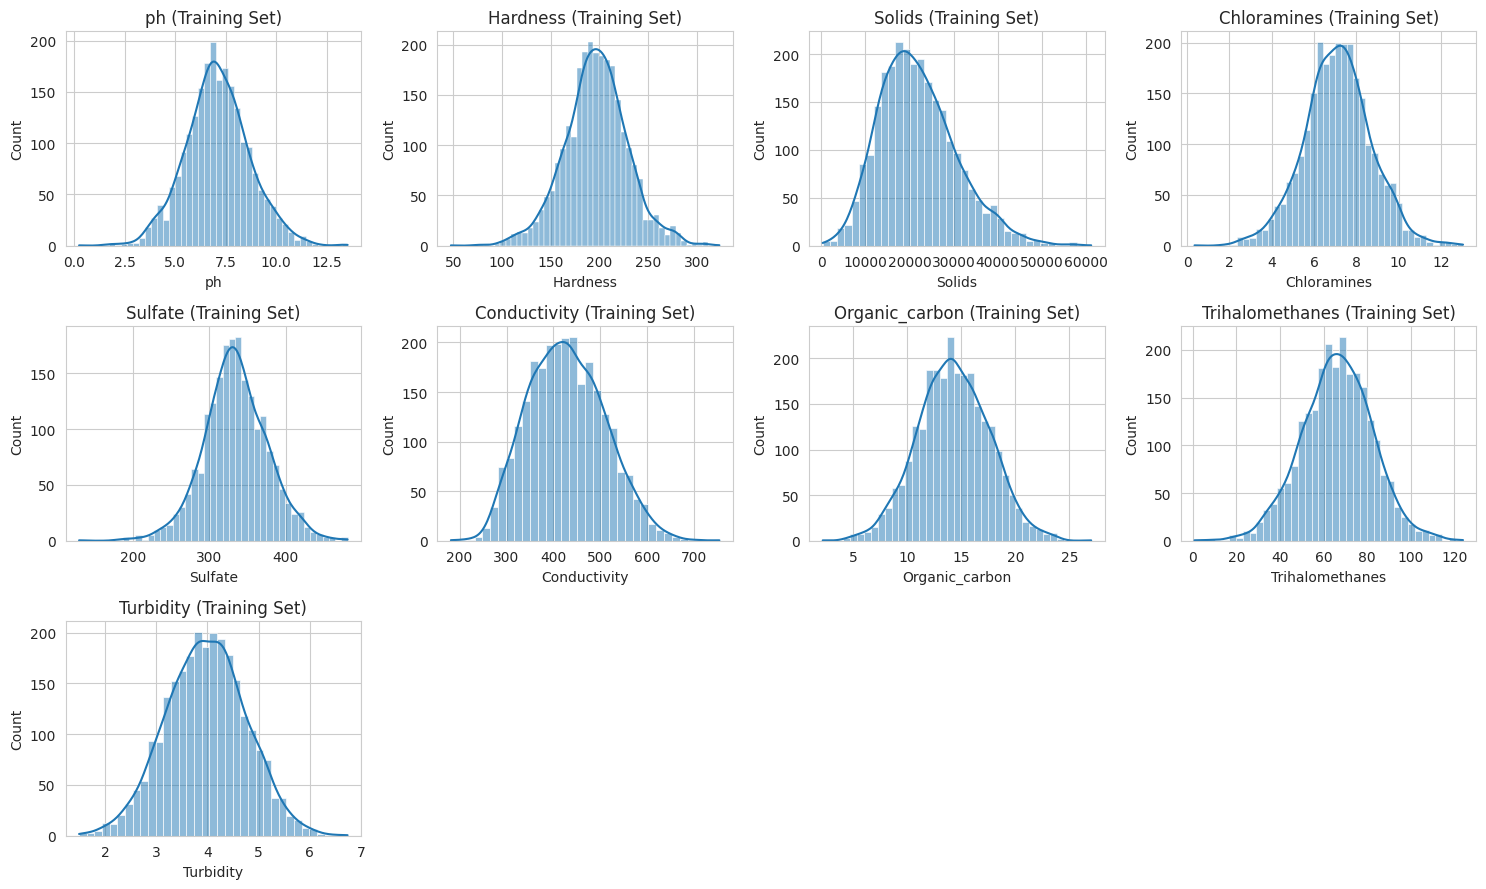

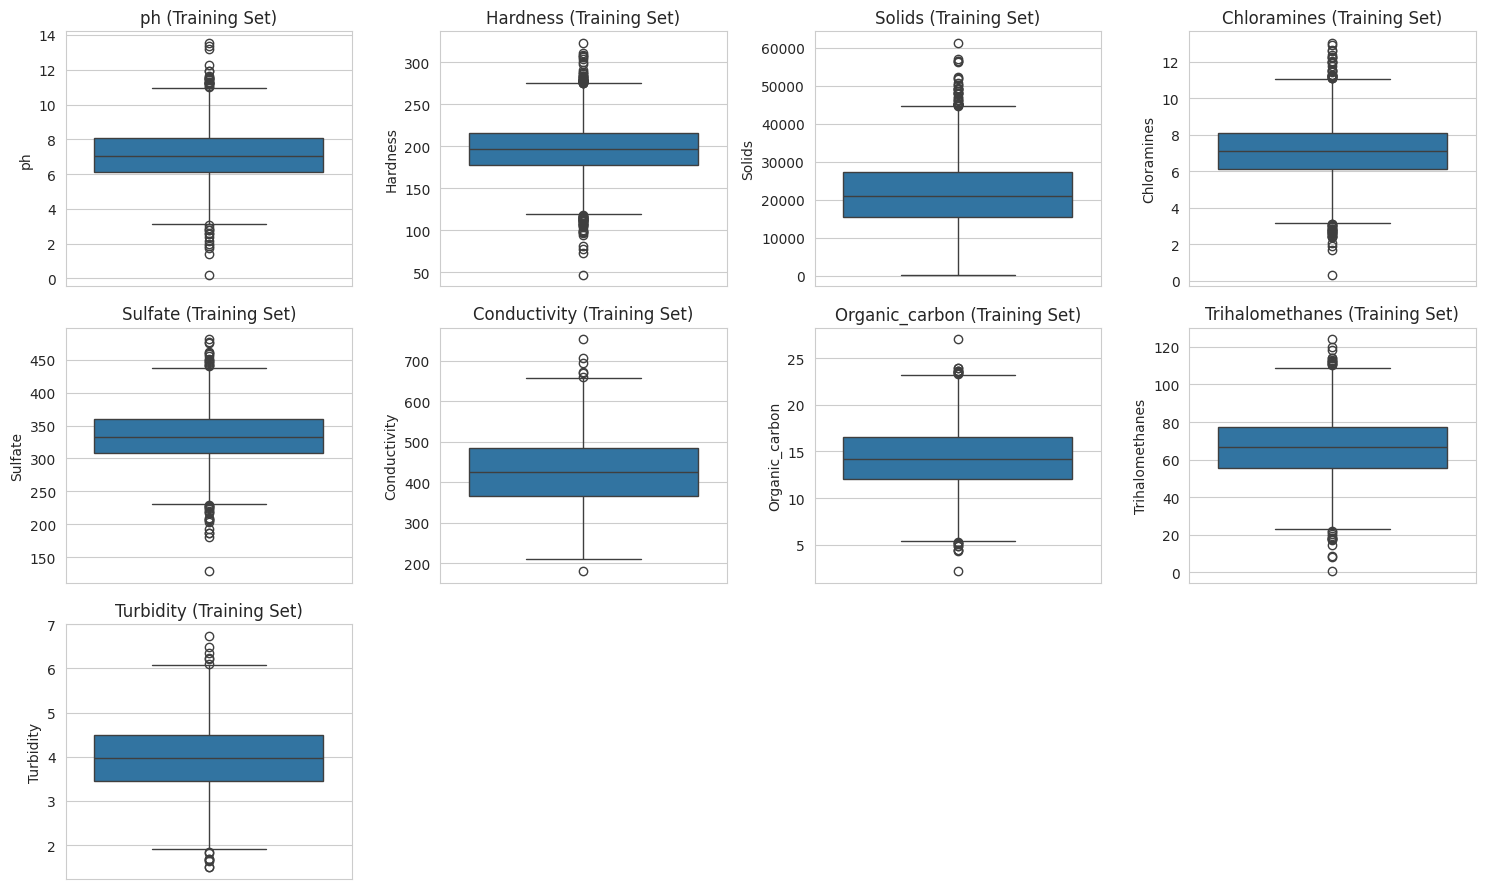

In [ ]:
# Ottengo i nomi di tutte le colonne delle feature dal set di training
all_cols_train = X_train.columns

# Definisco il numero di righe e colonne per i subplot
n_cols = 4
n_rows = (len(all_cols_train) + n_cols - 1) // n_cols

# Crea istogrammi per ciascuna variabile sul set di training
plt.figure(figsize=(15, n_rows * 3))
for i, col in enumerate(all_cols_train):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(X_train[col], kde=True)
    plt.title(f'{col} (Training Set)')
plt.tight_layout()
plt.show()

# Box plot per identificare gli outlier sul set di training
plt.figure(figsize=(15, n_rows * 3))
for i, col in enumerate(all_cols_train):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=X_train[col])
    plt.title(f'{col} (Training Set)')
plt.tight_layout()
plt.show()

### Analisi Approfondita dei Grafici di Distribuzione Univariata (Istogrammi e Box Plot)

Analizzando i grafici dell'analisi univariata (istogrammi e box plot), osservazioni per ciascuna variabile:

*   **pH**: L'istogramma mostra una distribuzione approssimativamente normale, centrata intorno a un pH neutro o leggermente alcalino (intorno a 7-8). I box plot confermano questa tendenza, anche se si notano alcuni outlier a valori di pH sia molto bassi che molto alti, indicando acque particolarmente acide o basiche.

*   **Hardness (Durezza)**: Anche la durezza sembra seguire una distribuzione quasi normale, con la maggior parte dei valori concentrati intorno alla media. I box plots mostrano una certa dispersione e alcuni outlier a valori di durezza elevata. L'acqua dura è comune e non necessariamente non potabile, ma valori estremi potrebbero essere un fattore da considerare.

*   **Solids (Solidi Totali Disciolti)**: Questa variabile presenta una distribuzione più asimmetrica, spostata verso destra, con una lunga coda di valori elevati. Il box plot evidenzia chiaramente numerosi outlier con concentrazioni molto alte di solidi disciolti. Questo è un aspetto importante, poiché un'eccessiva quantità di solidi disciolti può influire sulla potabilità.

*   **Chloramines (Clorammine)**: La distribuzione delle clorammine appare abbastanza simmetrica e concentrata intorno alla media. I box plots indicano la presenza di outlier sia inferiori che superiori, sebbene in misura minore rispetto ad altre variabili. Le clorammine sono usate per disinfettare l'acqua, quindi la loro presenza è attesa, ma concentrazioni anomale potrebbero essere significative.

*   **Sulfate (Solfati)**: Simile al pH e alla durezza, la distribuzione dei solfati sembra approssimativamente normale. I box plots mostrano alcuni outlier a valori alti. I solfati sono minerali presenti naturalmente, ma alte concentrazioni possono influire sul gusto.

*   **Conductivity (Conducibilità)**: La conducibilità mostra una distribuzione quasi normale, con alcuni outlier a valori elevati. La conducibilità è legata alla quantità di solidi disciolti, quindi è logico vedere pattern simili in termini di distribuzione e outlier.

*   **Organic_carbon (Carbonio Organico)**: La distribuzione del carbonio organico è abbastanza simmetrica, con la maggior parte dei valori raggruppati intorno alla media. I box plots rivelano la presenza di outlier a valori più alti. La presenza di carbonio organico può influire sulla qualità dell'acqua e favorire la crescita batterica.

*   **Trihalomethanes (Trialometani)**: La distribuzione dei trialometani appare anch'essa quasi normale. I box plots mostrano outlier a valori sia bassi che alti. I trialometani sono sottoprodotti della disinfezione e la loro concentrazione è regolamentata a causa dei potenziali rischi per la salute.

*   **Turbidity (Torbidità)**: La torbidità presenta una distribuzione approssimativamente normale. I box plots indicano alcuni outlier a valori sia inferiori che superiori. La torbidità è una misura della chiarezza dell'acqua; un'alta torbidità può indicare la presenza di particelle sospese.

*   **Potability (Potabilità)**: L'istogramma della potabilità, essendo una variabile binaria (0 o 1), mostra semplicemente il conteggio delle due classi, confermando lo sbilanciamento già osservato. Il box plot per una variabile binaria non fornisce informazioni significative sulla distribuzione continua, ma conferma visivamente la presenza delle due categorie.

In sintesi, dall'analisi univariata ho notato che la maggior parte delle variabili quantitative ha distribuzioni che si avvicinano alla normalità, ma molte presentano outlier, in particolare 'Solids'. La variabile target 'Potability' conferma lo sbilanciamento tra le classi potabile e non potabile.

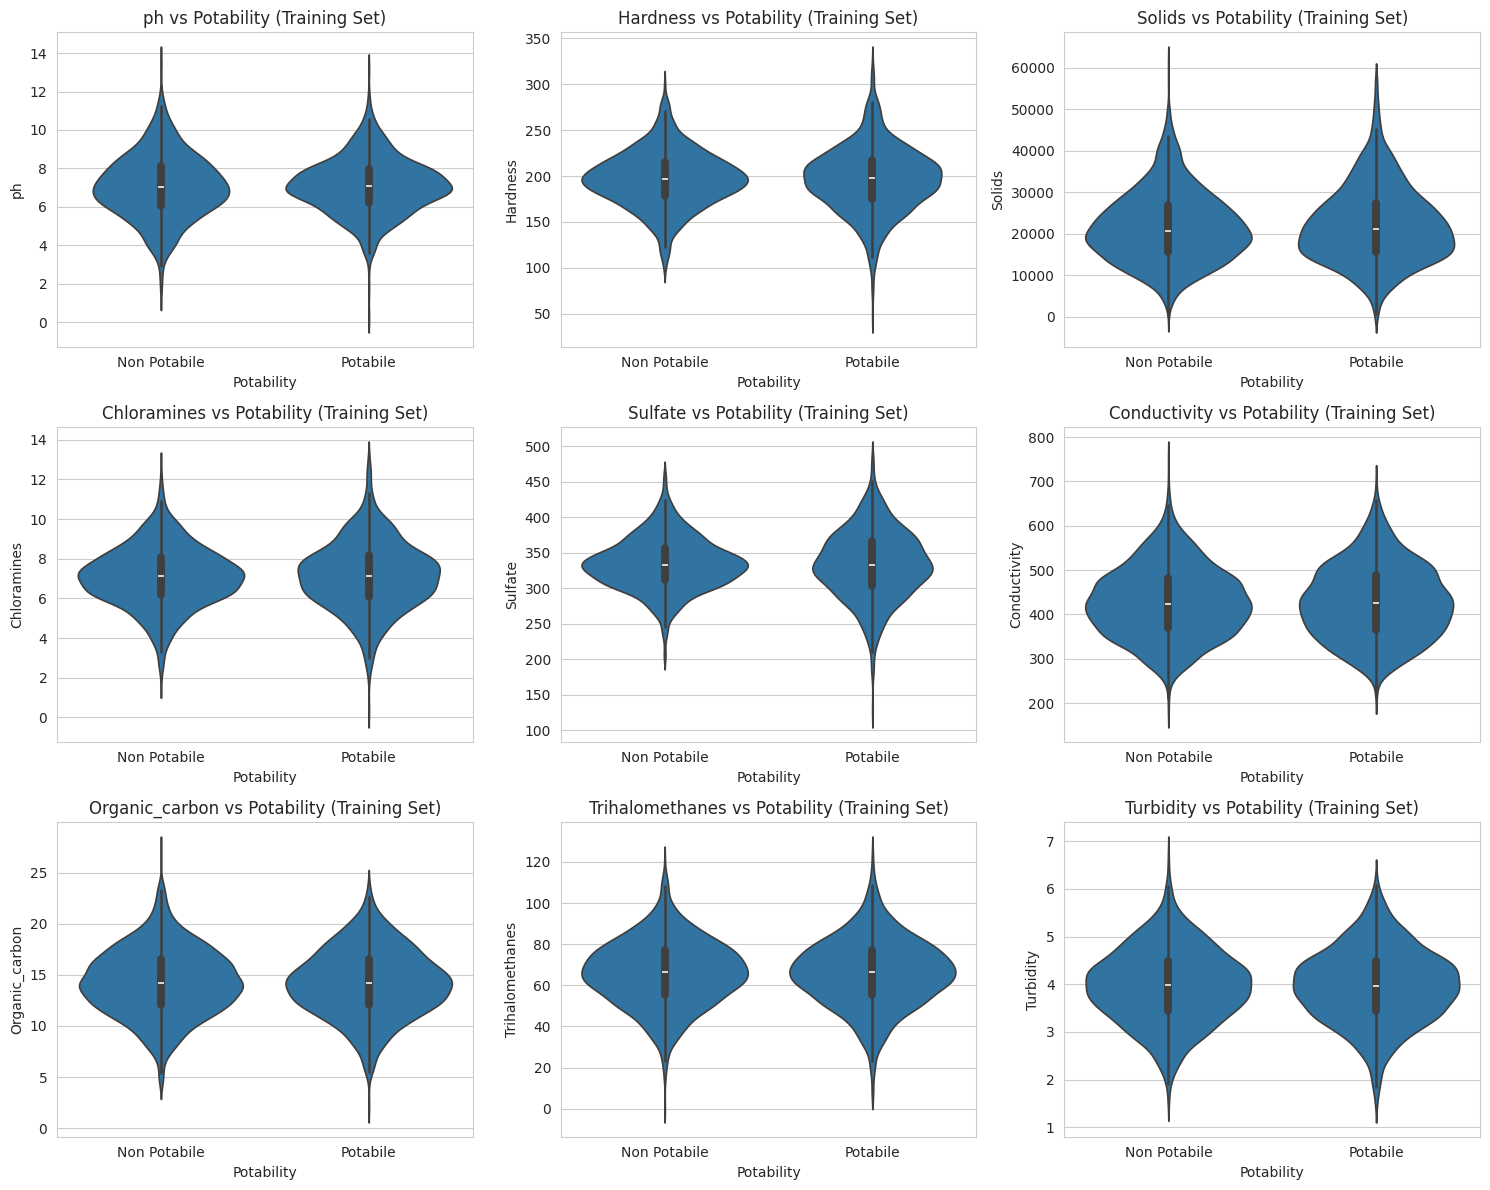

In [ ]:
# Ottengo i nomi delle colonne delle feature dal set di training
feature_cols = X_train.columns

# Definisce il numero di colonne per i subplot
n_cols = 3
n_rows = (len(feature_cols) + n_cols - 1) // n_cols

# Crea un DataFrame temporaneo per i grafici unendo X_train e y_train
train_df_for_plot = pd.concat([X_train, y_train], axis=1)

# Crea violin plot per ciascuna variabile rispetto al target sul set di training
plt.figure(figsize=(15, n_rows * 4))
for i, col in enumerate(feature_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.violinplot(data=train_df_for_plot, x='Potability', y=col)
    plt.title(f'{col} vs Potability (Training Set)')
    plt.xticks([0, 1], ['Non Potabile', 'Potabile'])
plt.tight_layout()
plt.show()

### Analisi Violin Plot
Osservando attentamente i violin plot che ho generato, posso trarre alcune conclusioni interessanti su come le distribuzioni delle caratteristiche differiscono tra l'acqua potabile e quella non potabile:

*   **pH**: I violin plot per il pH mostrano distribuzioni con forme e mediane abbastanza simili per entrambe le classi (potabile e non potabile). Questo suggerisce che, sebbene il pH sia un fattore importante, il suo valore da solo potrebbe non essere un discriminante tra acqua potabile e non potabile. Le "code" più larghe indicano una maggiore variabilità in entrambe le classi.

*   **Hardness (Durezza)**: Le distribuzioni della durezza per le due classi si sovrappongono notevolmente. Sembra che l'acqua potabile e non potabile possano avere range di durezza simili. Questo potrebbe indicare che la durezza da sola non è un predittore molto forte per la potabilità in questo dataset.

*   **Solids (Solidi Totali Disciolti)**: Qui inizio a vedere una differenza più marcata. La distribuzione dei solidi per l'acqua non potabile sembra essere spostata verso valori leggermente più alti rispetto all'acqua potabile, e presenta una coda più lunga verso valori elevati. Questo suggerisce che concentrazioni più alte di solidi disciolti potrebbero essere più comuni nell'acqua non potabile.

*   **Chloramines (Clorammine)**: Le distribuzioni delle clorammine appaiono abbastanza simili per entrambe le classi, con una sovrapposizione significativa. Come la durezza, le clorammine da sole potrebbero non essere un forte indicatore di potabilità.

*   **Sulfate (Solfati)**: I violin plot per i solfati mostrano distribuzioni che si sovrappongono, ma la "forma" della distribuzione potrebbe presentare sottili differenze tra le due classi. Potrebbe esserci una leggera tendenza verso valori di solfati leggermente diversi tra acqua potabile e non potabile, ma la distinzione non è netta.

*   **Conductivity (Conducibilità)**: Similmente ai solidi, la conducibilità mostra distribuzioni che sembrano leggermente diverse tra le due classi. La distribuzione per l'acqua non potabile potrebbe avere una forma leggermente diversa o una mediana leggermente spostata rispetto all'acqua potabile. Questo è logico, dato che la conducibilità è correlata ai solidi disciolti.

*   **Organic_carbon (Carbonio Organico)**: Le distribuzioni del carbonio organico per le due classi si sovrappongono ampiamente. Non sembra esserci una chiara separazione basata solo sulla quantità di carbonio organico.

*   **Trihalomethanes (Trialometani)**: Anche per i trialometani, le distribuzioni per l'acqua potabile e non potabile mostrano una notevole sovrapposizione. Questo indica che i trialometani da soli potrebbero non essere un forte discriminante.

*   **Turbidity (Torbidità)**: Le distribuzioni della torbidità per entrambe le classi sembrano abbastanza simili e si sovrappongono ampiamente. La torbidità da sola potrebbe non essere un indicatore chiave della potabilità in questo dataset.

In sintesi, dai violin plot, noto che caratteristiche come **Solids** e **Conductivity** mostrano le differenze di distribuzione più evidenti tra l'acqua potabile e non potabile rispetto ad altre caratteristiche come pH, Hardness, Chloramines, Organic\_carbon e Trihalomethanes, le cui distribuzioni per le due classi si sovrappongono in modo più significativo.

Questo mi suggerisce che **Solids** e **Conductivity** potrebbero essere features più informative per il nostro modello predittivo rispetto ad altre. Tuttavia, è importante ricordare che queste sono solo osservazioni bivariate; le interazioni tra più features potrebbero rivelare pattern più complessi.

In [5]:
# Funzione per contare gli outlier usando il metodo IQR per ciascuna classe di potabilità
def count_outliers_by_potability(df, feature_cols):
    outliers_count = {}
    for col in feature_cols:
        outliers_count[col] = {'Non Potabile (0)': {'Lower': 0, 'Upper': 0, 'Total': 0},
                               'Potabile (1)': {'Lower': 0, 'Upper': 0, 'Total': 0}}
        # Definisce le etichette delle classi per l'output
        class_labels = {0: 'Non Potabile (0)', 1: 'Potabile (1)'}

        for potability_class, label in class_labels.items():
            # Filtra il DataFrame per la classe di potabilità corrente
            subset_df = df[df['Potability'] == potability_class][col].dropna()

            if not subset_df.empty:
                # Calcola Q1, Q3 e IQR
                Q1 = subset_df.quantile(0.25)
                Q3 = subset_df.quantile(0.75)
                IQR = Q3 - Q1

                # Definisce i limiti per gli outlier
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

                # Conta gli outlier inferiori, superiori e totali
                lower_outliers = subset_df[subset_df < lower_bound]
                upper_outliers = subset_df[subset_df > upper_bound]

                outliers_count[col][label]['Lower'] = len(lower_outliers)
                outliers_count[col][label]['Upper'] = len(upper_outliers)
                outliers_count[col][label]['Total'] = len(lower_outliers) + len(upper_outliers)

            else:
                 # Nessun outlier se il subset è vuoto
                 outliers_count[col][label]['Lower'] = 0
                 outliers_count[col][label]['Upper'] = 0
                 outliers_count[col][label]['Total'] = 0


    return outliers_count

# Ottiene i nomi delle colonne delle feature dal set di training
feature_cols = X_train.columns

# Crea un DataFrame temporaneo per l'analisi unendo X_train e y_train
train_df_for_outliers = pd.concat([X_train, y_train], axis=1)

# Conta gli outlier
outliers_by_class = count_outliers_by_potability(train_df_for_outliers, feature_cols)

# Stampa i risultati
print("Conteggio e Percentuale degli outlier per feature (inferiori, superiori, totali), separati per classe di potabilità (metodo IQR):")
for feature, classes in outliers_by_class.items():
    print(f"\nFeature: {feature}")
    total_outliers_for_feature = 0
    total_non_null_for_feature = train_df_for_outliers[feature].dropna().shape[0] # Conteggio valori non nulli per la feature

    for class_label, counts in classes.items():
        print(f"  {class_label}:")
        print(f"    Outlier Inferiori: {counts['Lower']}")
        print(f"    Outlier Superiori: {counts['Upper']}")
        print(f"    Outlier Totali: {counts['Total']}")

        # Calcola e stampa la percentuale di outlier per la classe
        total_non_null_for_class = train_df_for_outliers[train_df_for_outliers['Potability'] == (0 if class_label == 'Non Potabile (0)' else 1)][feature].dropna().shape[0]
        if total_non_null_for_class > 0:
             percentage_outliers_class = (counts['Total'] / total_non_null_for_class) * 100
             print(f"    Percentuale Outlier (Classe): {percentage_outliers_class:.2f}%")
        else:
             print("    Percentuale Outlier (Classe): N/A (Nessun valore non nullo nella classe)")


        total_outliers_for_feature += counts['Total']

    # Calcola e stampa la percentuale totale di outlier per la feature
    if total_non_null_for_feature > 0:
        percentage_outliers = (total_outliers_for_feature / total_non_null_for_feature) * 100
        print(f"  Percentuale Totale Outlier (Feature): {percentage_outliers:.2f}%")
    else:
        print("  Percentuale Totale Outlier (Feature): N/A (Nessun valore non nullo)")

Conteggio e Percentuale degli outlier per feature (inferiori, superiori, totali), separati per classe di potabilità (metodo IQR):

Feature: ph
  Non Potabile (0):
    Outlier Inferiori: 8
    Outlier Superiori: 10
    Outlier Totali: 18
    Percentuale Outlier (Classe): 1.33%
  Potabile (1):
    Outlier Inferiori: 5
    Outlier Superiori: 10
    Outlier Totali: 15
    Percentuale Outlier (Classe): 1.70%
  Percentuale Totale Outlier (Feature): 1.48%

Feature: Hardness
  Non Potabile (0):
    Outlier Inferiori: 24
    Outlier Superiori: 22
    Outlier Totali: 46
    Percentuale Outlier (Classe): 2.88%
  Potabile (1):
    Outlier Inferiori: 15
    Outlier Superiori: 12
    Outlier Totali: 27
    Percentuale Outlier (Classe): 2.64%
  Percentuale Totale Outlier (Feature): 2.79%

Feature: Solids
  Non Potabile (0):
    Outlier Inferiori: 0
    Outlier Superiori: 22
    Outlier Totali: 22
    Percentuale Outlier (Classe): 1.38%
  Potabile (1):
    Outlier Inferiori: 0
    Outlier Superiori: 1

### Analisi degli Outlier e Relazione con i Violin Plot

Analizzando il conteggio dettagliato degli outlier per ciascuna feature, separato per classe di potabilità, e confrontando questi numeri con i violin plot che abbiamo generato in precedenza, posso fare alcune osservazioni:

Dai box plot e dai conteggi, è evidente che **molte feature presentano un certo numero di outlier**, sia inferiori che superiori, in entrambe le classi (potabile e non potabile). Tuttavia, in generale, la percentuale di outlier per ciascuna feature non è estremamente alta (spesso sotto il 3-4%), il che suggerisce che non ci sono valori estremi diffusi in modo massiccio nel dataset.

Guardando i violin plot, le "code" più sottili o più allungate dei violini corrispondono visivamente alla presenza di questi outlier. Ad esempio, per caratteristiche come 'Solids', dove abbiamo notato una coda più lunga verso valori elevati nei violin plot (specialmente per la classe non potabile), il conteggio degli outlier superiori tende ad essere un po' più elevato.

È interessante notare se la distribuzione degli outlier è significativamente diversa tra l'acqua potabile e quella non potabile. Dai numeri, non vedo una tendenza univoca: alcune feature hanno leggermente più outlier in una classe, altre nell'altra. Questo rinforza l'idea che la potabilità non sia determinata solo dalla presenza di valori estremi in una singola variabile, ma piuttosto da una combinazione di fattori.

Ad esempio, 'Conductivity' e 'Organic_carbon' sembrano avere percentuali totali di outlier relativamente basse. Questo si riflette nei violin plot, dove le distribuzioni tendono ad essere più concentrate senza code estremamente lunghe.

'Hardness' e 'Chloramines' mostrano una percentuale di outlier leggermente superiore rispetto ad altre, e questo si può intravedere nei violin plot come una maggiore dispersione dei punti, anche se le forme centrali dei violini sono simili tra le classi.

In sintesi, l'analisi quantitativa degli outlier conferma le osservazioni visive fatte con i box plot e i violin plot. Mi dice che, sebbene gli outlier siano presenti, la loro frequenza non è tale da dominare la distribuzione delle feature e non sembrano essere un discriminante *primario* tra acqua potabile e non potabile presi singolarmente. Questo rafforza ulteriormente la necessità di utilizzare modelli che possano catturare relazioni complesse e interazioni tra feature, piuttosto che affidarsi a semplici soglie o alla gestione aggressiva degli outlier come unico passo di pre-elaborazione, la loro presenza non sembra minare la validità generale del dataset in modo drastico.

In [6]:
# Inizializza il modello Isolation Forest
# contamination='auto' stima la proporzione di outlier nel dataset.
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# Addestra il modello sul set di training (escludendo la colonna target per l'addestramento del modello di outlier)
# Consideriamo solo le feature per l'addestramento del rilevatore di outlier
iso_forest.fit(X_train.dropna()) # Isolation Forest non gestisce i NaN, quindi usiamo dropna

# Prevedi gli outlier (Anomaly: -1, Inlier: 1)
# Usiamo predict sul set di training (senza NaN) per valutare quali punti vengono considerati outlier
outliers_iso_forest = iso_forest.predict(X_train.dropna())

# Aggiunge i punteggi di anomalia al DataFrame temporaneo per l'analisi
# Calcola i punteggi di anomalia (più basso è il punteggio, più anomalo è il punto)
anomaly_scores = iso_forest.decision_function(X_train.dropna())

# Crea un DataFrame con i risultati
outliers_df = X_train.dropna().copy()
outliers_df['anomaly_score'] = anomaly_scores
outliers_df['is_outlier_iso_forest'] = outliers_iso_forest

# Visualizza i punti con i punteggi di anomalia più bassi (i più probabili outlier)
print("Punti con i punteggi di anomalia più bassi (potenziali outlier multivariati):")
display(outliers_df.sort_values(by='anomaly_score').head(10))

# Conta quanti punti sono stati classificati come outlier (-1)
n_outliers_iso_forest = (outliers_iso_forest == -1).sum()
print(f"\nNumero totale di outlier identificati da Isolation Forest (sul set di training senza NaN): {n_outliers_iso_forest}")

Punti con i punteggi di anomalia più bassi (potenziali outlier multivariati):


ph    Hardness        Solids  Chloramines     Sulfate  \
275   5.324942  280.089655  35344.658047    13.043806  180.206746   
1554  8.942046  215.673786  56488.672413     3.231438  129.000000   
1186  9.484703  122.906991  56351.396304     4.219711  219.553437   
1106  6.879959  163.593339  44586.812651     2.741712  219.148935   
1765  9.497261  124.482810  33681.330140     4.814656  427.184508   
3218  5.859822  287.975540   3640.734320     4.072626  391.697385   
1669  5.915944  274.263618   6967.735565    10.069435  247.645743   
227   7.083779  112.820254   8580.245561     4.210284  234.852699   
1537  7.381758  203.460302   1372.091043    11.129154  475.737460   
2694  3.676845  173.677702  22581.224488    12.653362  289.126846   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  anomaly_score  \
275     392.421496       10.504820        55.084668   4.427138      -0.093428   
1554    541.915468        9.313771        70.828374   4.354288      -0.088794   
1186    480.848063       13.533433        41.731219   4.132274      -0.087799   
1106    554.045105       16.521942        67.533260   5.688207      -0.082118   
1765    530.217008       19.970318        49.809841   5.242105      -0.078977   
3218    447.121861        6.363175        49.155291   3.426634      -0.077195   
1669    321.236814       12.092167        39.448593   2.585849      -0.076274   
227     434.747715       23.399516        94.160307   3.887681      -0.072015   
1537    361.342496       16.548438        55.132546   3.338022      -0.067907   
2694    599.729246        8.386407        49.658554   5.461473      -0.066749   

      is_outlier_iso_forest  
275                      -1  
1554                     -1  
1186                     -1  
1106                     -1  
1765                     -1  
3218                     -1  
1669                     -1  
227                      -1  
1537                     -1  
2694                     -1


Numero totale di outlier identificati da Isolation Forest (sul set di training senza NaN): 123


### Analisi dei Risultati di Isolation Forest e Gestione degli Outlier

Ho utilizzato Isolation Forest per identificare outlier basati su combinazioni multivariate di feature. I risultati ci mostrano un certo numero di punti che il modello considera anomali. Questi punti potrebbero non essere necessariamente estremi in una singola dimensione (come quelli identificati dall'IQR), ma si discostano dal comportamento tipico del resto del dataset se considerate insieme più feature.

**Analisi dei risultati:**

*   Il numero totale di outlier identificati da Isolation Forest (sul set di training senza NaN) ci dà un'idea della presenza di pattern di dati insoliti che non sono evidenti dall'analisi univariata.
*   I punti con i punteggi di anomalia più bassi sono quelli che il modello considera più "isolati" e quindi più probabili outlier multivariati.

**Approccio alla gestione degli outlier:**

Data la natura del nostro problema (classificazione della potabilità dell'acqua) e le osservazioni fatte finora, ecco un approccio consigliato per la gestione degli outlier:

1.  **Non eliminare indiscriminatamente:** L'eliminazione pura degli outlier, soprattutto se sono pochi, può rimuovere informazioni preziose e ridurre la dimensione del dataset. Inoltre, in un problema di classificazione, un outlier nella classe minoritaria potrebbe essere un punto importante per definire il confine tra le classi.
2.  **Considerare l'impatto sul modello:** Alcuni modelli di machine learning (come quelli basati su alberi decisionali) sono relativamente robusti agli outlier. Altri (come regressione lineare) possono essere più sensibili. Poiché esploreremo diversi tipi di modelli, è utile considerare strategie che funzionino bene per una gamma di algoritmi.
3.  **Strategie alternative:** Invece di eliminare, si potrebbe considerare:
    *   **Capping (Winsorizing):** Limitare i valori estremi a un certo percentile (ad esempio, il 5° e il 95° percentile). Questo riduce l'impatto degli outlier senza rimuovere i dati.

Considerando che le percentuali di outlier (sia univariati che multivariati identificati da Isolation Forest) non sembrano essere massicce e che l'eliminazione potrebbe ridurre il set di training (soprattutto dopo aver gestito i valori mancanti), proseguirò **non eliminando gli outlier in questa fase**.


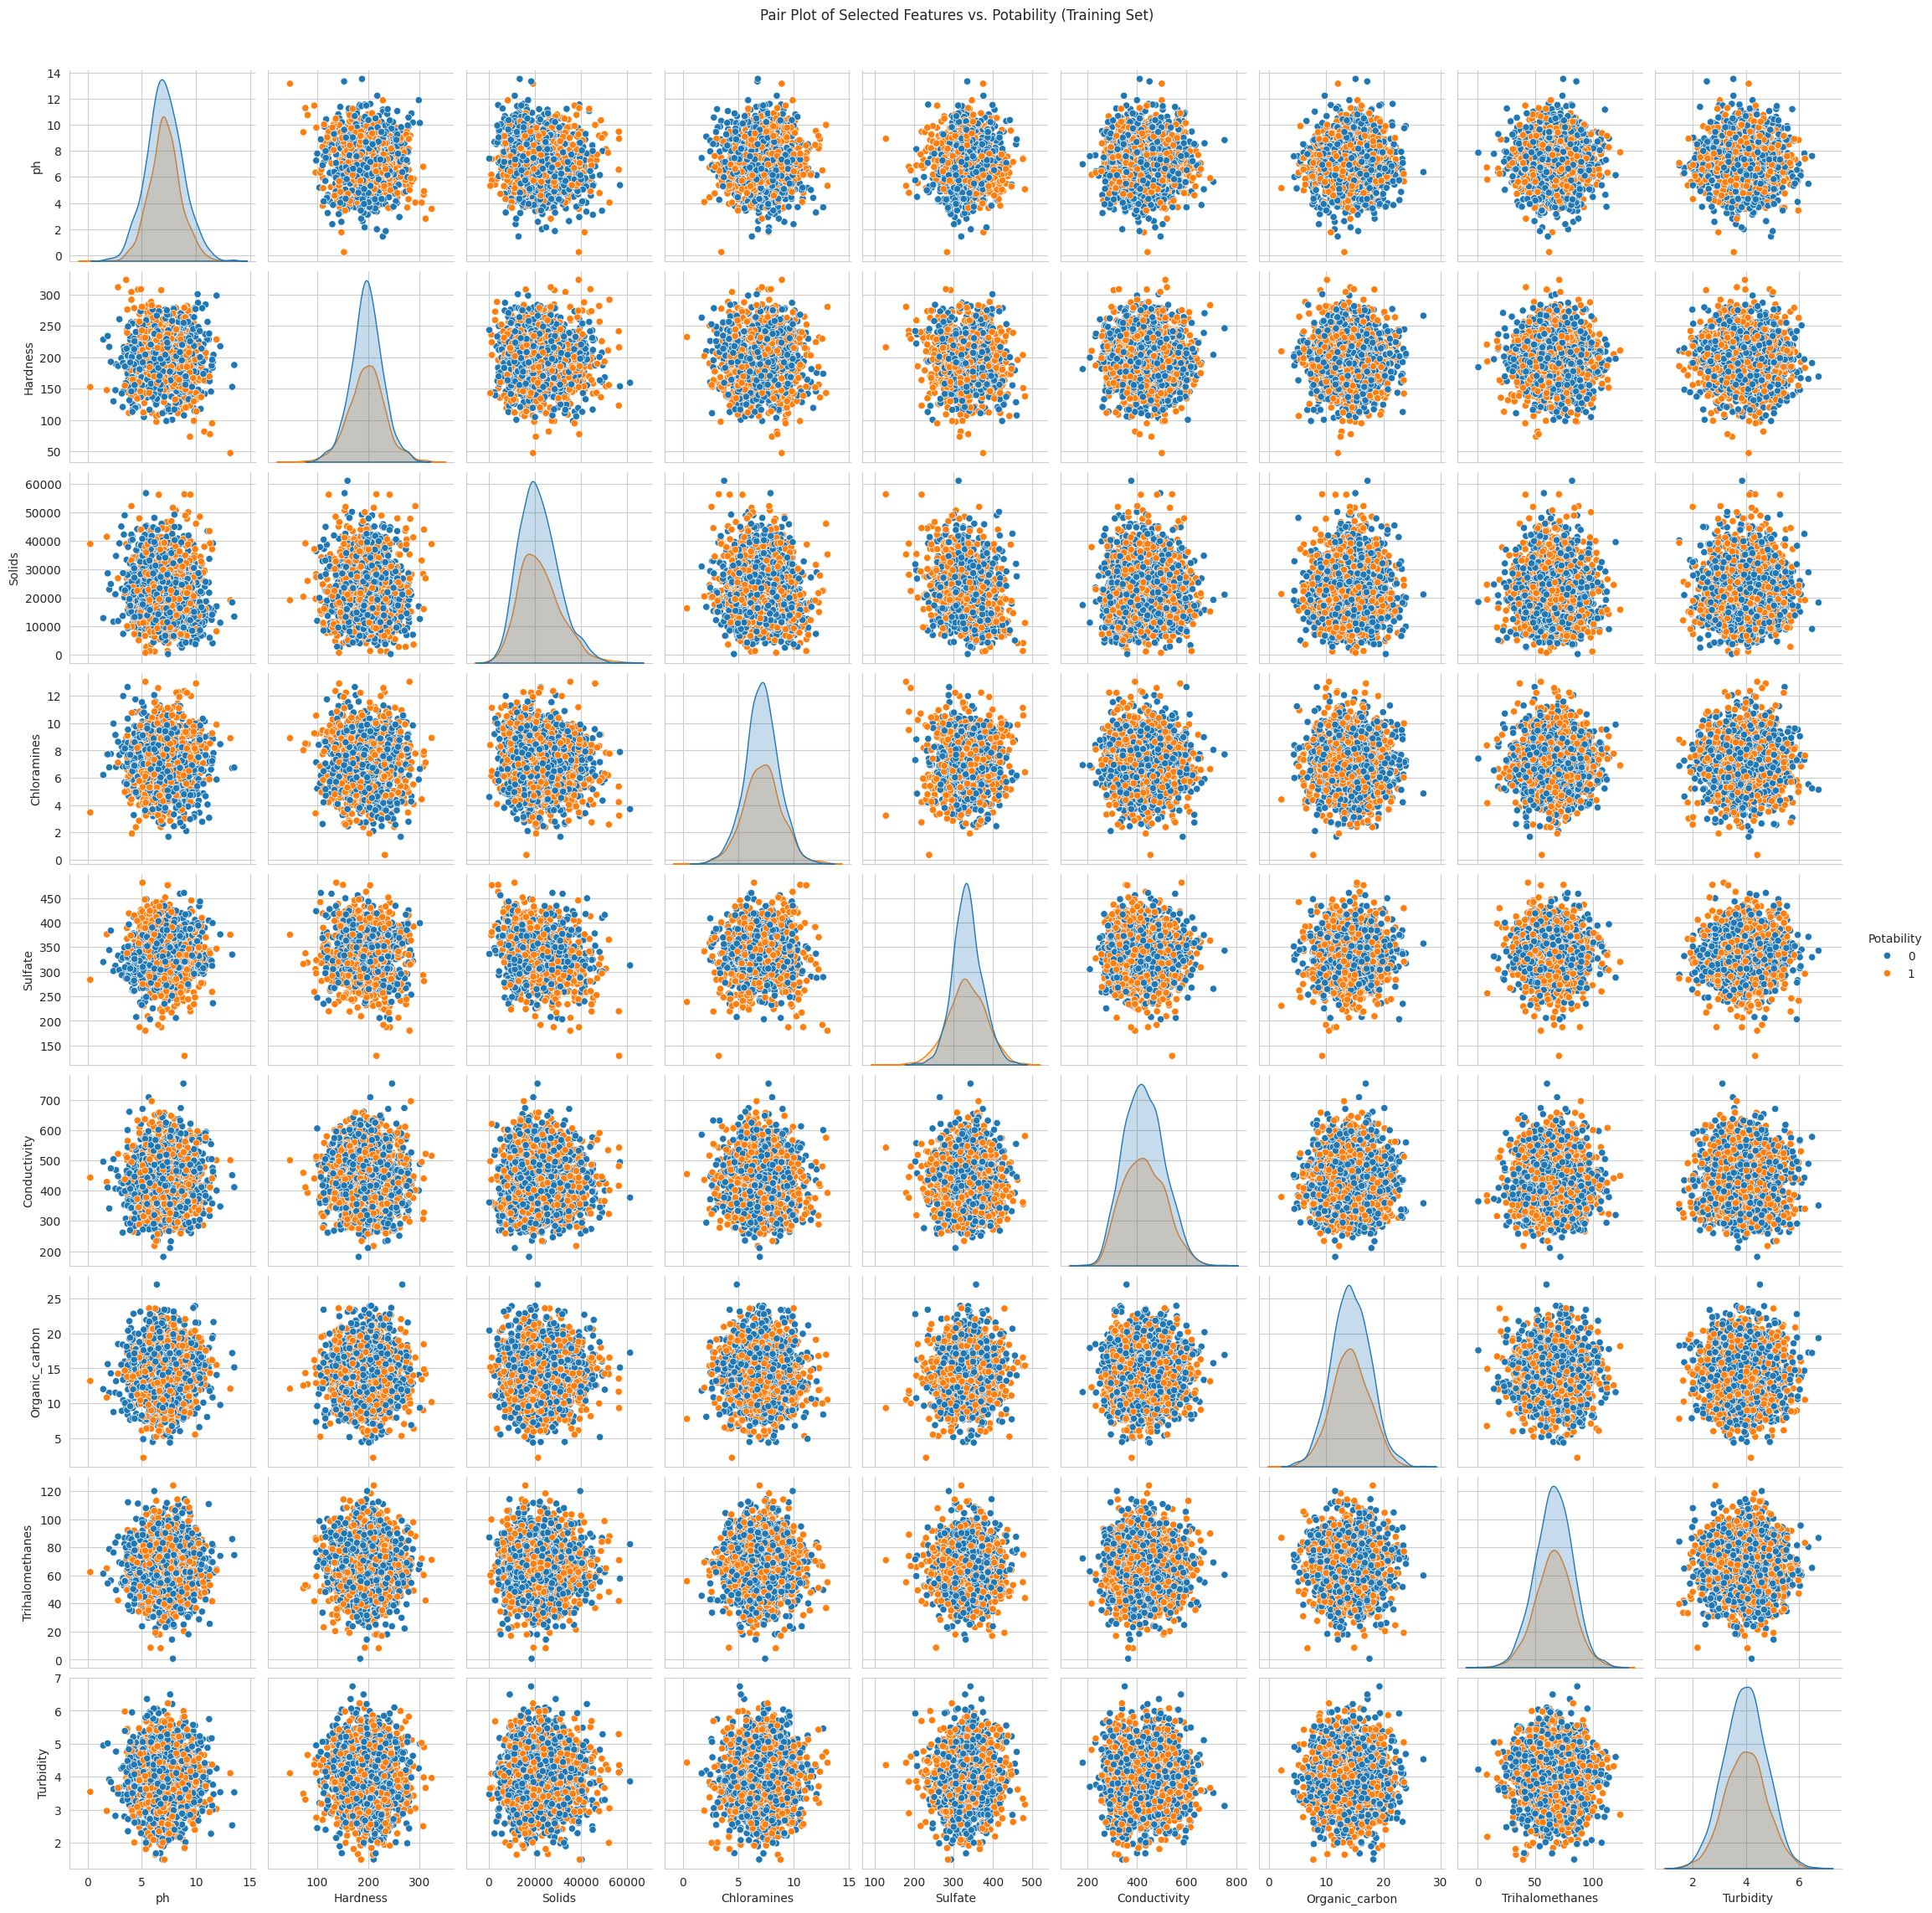

In [ ]:
cols_for_pairplot = X_train.columns.tolist() + ['Potability']

# Crea un DataFrame temporaneo con le colonne dal set di training
train_df_subset = train_df_for_plot[cols_for_pairplot]

# Crea il pair plot, colorando i punti in base alla Potability
sns.pairplot(train_df_subset, hue='Potability', diag_kind='kde')
plt.suptitle('Pair Plot of Selected Features vs. Potability (Training Set)', y=1.02)
plt.show()

### Analisi del Pair Plot

Analizzando il pair plot che include tutte le feature colorate in base alla potabilità, noto diverse cose interessanti:

*   **Distribuzioni Univariate (sulla diagonale):** Le distribuzioni di densità stimata sulla diagonale confermano quanto avevamo già osservato con gli istogrammi e i violin plot. Variabili come 'ph', 'Hardness', 'Chloramines', 'Sulfate', 'Organic\_carbon' e 'Trihalomethanes' mostrano distribuzioni abbastanza simili per entrambe le classi di potabilità, con una notevole sovrapposizione. 'Solids' e 'Conductivity' sembrano avere distribuzioni leggermente più differenziate, con 'Solids' che mostra una coda più lunga verso valori elevati per l'acqua non potabile e 'Conductivity' che potrebbe avere una forma leggermente diversa tra le due classi. 'Turbidity' ha distribuzioni molto simili. Questo rinforza l'idea che 'Solids' e 'Conductivity' potrebbero essere predittori più forti delle altre variabili prese singolarmente.

*   **Relazioni Bivariate (fuori dalla diagonale):** Le nuvole di punti fuori dalla diagonale mostrano le relazioni tra coppie di feature. In molti casi, le nuvole di punti per l'acqua potabile (arancione) e non potabile (blu) si sovrappongono ampiamente, rendendo difficile distinguere le due classi basandosi solo su coppie di queste variabili. Tuttavia, ci sono alcune aree dove si possono notare sottili differenze o raggruppamenti. Ad esempio, nella relazione tra 'Solids' e 'Conductivity', si può vedere una certa correlazione positiva (all'aumentare dei solidi, aumenta la conducibilità, il che ha senso dal punto di vista chimico). Non vedo una separazione netta tra le classi in questa relazione, ma la densità dei punti potrebbe variare leggermente.

*   **Assenza di Separazione Lineare Chiara:** La cosa più evidente da questo pair plot è che non esiste una singola coppia di feature che permetta di separare linearmente e completamente l'acqua potabile da quella non potabile. I punti blu e arancioni sono molto mescolati nella maggior parte dei grafici a dispersione. Questo mi suggerisce che la potabilità non è determinata da un semplice cutoff su una o due variabili, ma è probabilmente una funzione più complessa di diverse feature che interagiscono tra loro.

In sintesi, il pair plot conferma che il problema della classificazione della potabilità dell'acqua in questo dataset non è banale. Le variabili prese singolarmente o a coppie mostrano una notevole sovrapposizione tra le classi. Questo indica che un modello predittivo dovrà probabilmente considerare l'interazione di più feature per fare previsioni accurate. Le feature 'Solids' e 'Conductivity' continuano a sembrare le più promettenti in termini di differenze di distribuzione tra le classi, ma non sono sufficienti da sole.

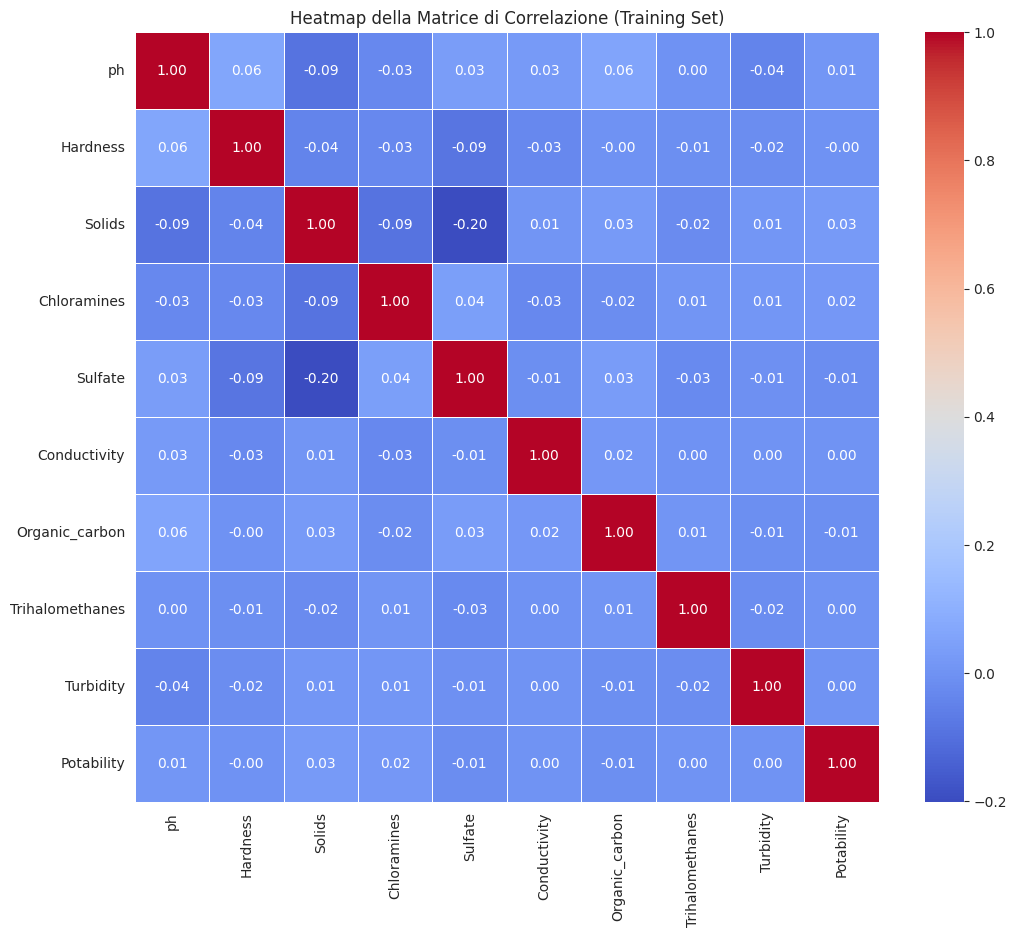

In [ ]:
# Calcola la matrice di correlazione sul set di training
correlation_matrix = train_df_for_plot.corr()

# Crea la heatmap della matrice di correlazione
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap della Matrice di Correlazione (Training Set)')
plt.show()

### Analisi della Heatmap della Matrice di Correlazione

Analizzando la heatmap della matrice di correlazione generata sul set di training, noto quanto segue:

*   **Correlazioni con la Potabilità:** Guardando l'ultima riga (o colonna) relativa a 'Potability', i valori di correlazione lineare con le singole feature sono generalmente molto bassi. Il valore più alto in termini assoluti sembra essere con 'Solids' (circa 0.03), seguito da 'Chloramines' (circa 0.02) e 'ph' (circa 0.01). Questo conferma quanto avevamo già intuito dai pair plot: nessuna singola feature ha una forte relazione lineare con la potabilità. Questo suggerisce che la potabilità è probabilmente influenzata da una combinazione più complessa di fattori, piuttosto che da un semplice aumento o diminuzione di una singola proprietà.

*   **Correlazioni tra le Feature:** Ci sono alcune correlazioni tra le feature, anche se nessuna è estremamente alta. Le correlazioni più notevoli includono:
    *   'Solids' e 'Sulfate': C'è una correlazione negativa moderata (circa -0.20). Questo è un po' sorprendente e potrebbe meritare un'ulteriore indagine chimica o contestuale per capire perché all'aumentare dei solidi disciolti, i solfati tendono a diminuire in questo dataset.
    *   Ci sono anche correlazioni minori ma visibili tra altre coppie, come 'ph' e 'Hardness', 'Chloramines', 'Sulfate', o tra 'Hardness' e 'Sulfate', 'Solids', ecc. Tuttavia, la maggior parte di queste correlazioni tra feature sono deboli.

*   **Assenza di Forte Multicollinearità:** Poiché non ci sono correlazioni molto alte tra le feature (ad esempio, superiori a 0.7 o 0.8 in valore assoluto), la multicollinearità non sembra essere un problema significativo in questo dataset per i modelli che ne sono sensibili.

In sintesi, l'heatmap conferma che non esistono singole feature con una forte correlazione lineare con la potabilità. Questo indica che un modello predittivo dovrà probabilmente sfruttare le interazioni tra le feature per ottenere buone prestazioni. Le correlazioni tra le feature sono generalmente basse, con l'eccezione notevole tra 'Solids' e 'Sulfate'. Questa analisi della correlazione lineare ci dà un quadro quantitativo delle relazioni, complementare alle visualizzazioni che abbiamo già fatto.

## 5. Gestione dei Valori Mancanti

### Scelta della Strategia di Imputazione

La scelta della strategia per imputare i valori mancanti nelle colonne 'ph', 'Sulfate' e 'Trihalomethanes' è stata ponderata considerando le osservazioni nell'EDA per queste colonne, pur avendo distribuzioni che si avvicinano alla normalità per la maggior parte dei casi, presentano comunque una certa quantità di **outlier**, come evidenziato dai box plot e dal conteggio basato sull'IQR.

In questo contesto, l'**imputazione con la mediana** emerge come una strategia robusta e preferibile rispetto all'imputazione con la media per diversi motivi:

1.  **Robustezza agli Outlier:** La mediana è significativamente meno influenzata dalla presenza di valori estremi rispetto alla media. Se avessimo utilizzato la media su colonne con outlier, il valore imputato sarebbe stato distorto da questi valori anomali, potenzialmente introducendo un bias nei dati imputati e influenzando negativamente i modelli successivi. La mediana, essendo una misura di tendenza centrale più resistente, fornisce un valore di imputazione che rappresenta meglio il "centro" della distribuzione **senza essere trascinata** dagli outlier.

2.  **Preservazione della Distribuzione (Relativa):** Sebbene nessuna imputazione semplice possa perfettamente replicare la distribuzione originale, l'imputazione con la mediana tende a distorcere meno la forma della distribuzione rispetto all'imputazione con la media in presenza di asimmetrie o outlier. Mantenere la forma della distribuzione il più fedele possibile è importante per alcuni algoritmi di machine learning che fanno assunzioni sulla distribuzione dei dati.

**Importanza del Calcolo sul Training Set:**

Ho calcolato le mediane **esclusivamente sul set di training**. Queste mediane calcolate sul training set sono poi state utilizzate per imputare i valori mancanti sia nel set di training che nel set di test. Questo approccio garantisce che il processo di imputazione sul set di test simuli realisticamente ciò che accadrebbe in un scenario del mondo reale, dove non avremmo accesso ai dati futuri (il set di test) durante la fase di addestramento.


In [8]:
# Calcola le mediane dal set di training per le colonne con valori mancanti
median_ph = X_train['ph'].median()
median_sulfate = X_train['Sulfate'].median()
median_trihalomethanes = X_train['Trihalomethanes'].median()

# Stampa le mediane calcolate
print(f"Mediana di 'ph' (Training Set): {median_ph:.2f}")
print(f"Mediana di 'Sulfate' (Training Set): {median_sulfate:.2f}")
print(f"Mediana di 'Trihalomethanes' (Training Set): {median_trihalomethanes:.2f}")

# Imputa i valori mancanti nel set di training con le mediane calcolate
X_train_imputed = X_train.copy()
X_train_imputed['ph'] = X_train_imputed['ph'].fillna(median_ph)
X_train_imputed['Sulfate'] = X_train_imputed['Sulfate'].fillna(median_sulfate)
X_train_imputed['Trihalomethanes'] = X_train_imputed['Trihalomethanes'].fillna(median_trihalomethanes)

# Imputa i valori mancanti nel set di test con le *stesse* mediane calcolate sul training set
X_test_imputed = X_test.copy()
X_test_imputed['ph'] = X_test_imputed['ph'].fillna(median_ph)
X_test_imputed['Sulfate'] = X_test_imputed['Sulfate'].fillna(median_sulfate)
X_test_imputed['Trihalomethanes'] = X_test_imputed['Trihalomethanes'].fillna(median_trihalomethanes)

# Verifica che non ci siano più valori nulli dopo l'imputazione nei set imputati
print("\nConteggio valori nulli dopo l'imputazione (Training Set):")
display(X_train_imputed.isnull().sum())

print("\nConteggio valori nulli dopo l'imputazione (Test Set):")
display(X_test_imputed.isnull().sum())

Mediana di 'ph' (Training Set): 7.04
Mediana di 'Sulfate' (Training Set): 333.07
Mediana di 'Trihalomethanes' (Training Set): 66.57

Conteggio valori nulli dopo l'imputazione (Training Set):


ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
dtype: int64


Conteggio valori nulli dopo l'imputazione (Test Set):


ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
dtype: int64

## 6. Test di Ipotesi

### Scelta del Test U di Mann-Whitney

Per valutare se le distribuzioni di ciascuna feature continua differiscono significativamente tra le due classi della variabile target binaria ('Potability'), ho scelto il **Test U di Mann-Whitney**.

I motivi principali per questa scelta sono:

1.  **Confronto tra Gruppi:** È un test appropriato per confrontare una variabile continua tra due gruppi indipendenti (acqua potabile vs non potabile).
2.  **Test Non Parametrico:** A differenza del t-test, non assume la normalità delle distribuzioni delle feature, il che lo rende più robusto in presenza di outlier o distribuzioni non perfettamente normali, come abbiamo osservato nella nostra EDA.
3.  **Robustezza:** Lavorando sui ranghi dei dati, è meno sensibile ai valori estremi rispetto ai test parametrici come il t-test.

Un p-value inferiore a 0.05 nei risultati del test suggerisce una differenza statisticamente significativa nella distribuzione della feature tra i due gruppi di potabilità.

In [9]:
# Sopprime i FutureWarning specifici di scipy.stats che potrebbero comparire con dati simili o vuoti
warnings.filterwarnings("ignore", category=FutureWarning)

# Nomi delle colonne delle feature dal set di training
feature_cols = X_train.columns

print("Risultati del Test U di Mann-Whitney per ciascuna feature vs Potability (Training Set Imputato):")
print("Un p-value < 0.05 suggerisce una differenza statisticamente significativa tra acqua potabile e non potabile per quella feature.")
print("-" * 100)

# Esegui il test U di Mann-Whitney per ciascuna feature
for col in feature_cols:
    # Separa i dati per la feature corrente in base alla classe di potabilità
    data_potable = X_train[y_train == 1][col].dropna()
    data_non_potable = X_train[y_train == 0][col].dropna()

    # COntrollo che ci siano dati in entrambi i gruppi
    if len(data_potable) > 0 and len(data_non_potable) > 0:
        # Esegui il test U di Mann-Whitney
        stat, p_value = mannwhitneyu(data_non_potable, data_potable, alternative='two-sided')

        # Stampa i risultati
        print(f"Feature: {col}")
        print(f"  Statistica U: {stat:.2f}")
        print(f"  P-value: {p_value:.4f}")
        if p_value < 0.05:
            print("  Risultato: Statisticamente Significativo (p < 0.05)")
        else:
            print("  Risultato: Non Statisticamente Significativo (p >= 0.05)")
        print("-" * 30)
    else:
        print(f"Feature: {col}")
        print("  Risultato: Non è stato possibile eseguire il test (dati insufficienti in uno o entrambi i gruppi).")
        print("-" * 30)

# Riattiva i warning di FutureWarning
warnings.filterwarnings("default", category=FutureWarning)

Risultati del Test U di Mann-Whitney per ciascuna feature vs Potability (Training Set Imputato):
Un p-value < 0.05 suggerisce una differenza statisticamente significativa tra acqua potabile e non potabile per quella feature.
----------------------------------------------------------------------------------------------------
Feature: ph
  Statistica U: 585774.00
  P-value: 0.5113
  Risultato: Non Statisticamente Significativo (p >= 0.05)
------------------------------
Feature: Hardness
  Statistica U: 815857.00
  P-value: 0.9696
  Risultato: Non Statisticamente Significativo (p >= 0.05)
------------------------------
Feature: Solids
  Statistica U: 798470.00
  P-value: 0.3377
  Risultato: Non Statisticamente Significativo (p >= 0.05)
------------------------------
Feature: Chloramines
  Statistica U: 803318.00
  P-value: 0.4826
  Risultato: Non Statisticamente Significativo (p >= 0.05)
------------------------------
Feature: Sulfate
  Statistica U: 478969.00
  P-value: 0.8120
  Risultat

### Analisi dei Risultati del Test U di Mann-Whitney

Dopo aver eseguito il Test U di Mann-Whitney per ciascuna feature continua confrontando le distribuzioni tra i campioni di acqua potabile e non potabile, i risultati mostrano che per **tutte le feature**, il **p-value è maggiore di 0.05**.

Cosa significa questo?

Con un livello di significatività comune di 0.05, non è possibile rifiutare l'ipotesi nulla per nessuna delle feature. L'ipotesi nulla in questo test è che non ci sia una differenza significativa nella distribuzione della feature tra i due gruppi (potabile e non potabile).

Pertanto, i risultati suggeriscono che, considerando ogni feature **individualmente**, non c'è una differenza statisticamente significativa nella loro distribuzione tra l'acqua potabile e quella non potabile.

Questo risultato rafforza le osservazioni fatte durante l'EDA (dai pair plot e dalla heatmap di correlazione) che indicavano una notevole sovrapposizione tra le classi per molte feature e correlazioni lineari molto basse con la variabile target. Sembra che la potabilità dell'acqua in questo dataset non sia determinata da una singola proprietà che si distingue chiaramente, ma piuttosto da **combinazioni e interazioni più complesse tra le diverse feature**.

Quindi, mentre i test d'ipotesi univariati non hanno identificato feature singolarmente significative, ciò non significa che le feature non siano predittive. Significa semplicemente che la loro capacità predittiva risiede probabilmente nelle loro interazioni piuttosto che nelle loro distribuzioni individuali. Questo sottolinea l'importanza di utilizzare modelli di machine learning che possono catturare tali interazioni.

## 7. Test Modelli Base

Vantaggi e svantaggi dei modelli selezionati in questo contesto

### Regressione Logistica

La Regressione Logistica è un algoritmo di classificazione lineare, semplice e ampiamente utilizzato.

*   **Vantaggi:**
    *   **Interpretazione:** È relativamente facile da interpretare. Possiamo capire l'impatto di ciascuna feature sulla probabilità che l'acqua sia potabile (anche se in questo dataset le relazioni lineari sembrano deboli).
    *   **Efficienza Computazionale:** È veloce da addestrare, soprattutto su dataset di dimensioni moderate.
    *   **Buon Punto di Partenza:** Spesso fornisce una buona baseline per confrontare modelli più complessi.

*   **Svantaggi:**
    *   **Assunzione di Linearità:** Presume una relazione lineare tra le feature e il log-odds della variabile target. La nostra EDA ha suggerito che le relazioni potrebbero non essere prettamente lineari e che le interazioni tra feature sono importanti.
    *   **Sensibilità agli Outlier:** Può essere sensibile agli outlier, anche se l'imputazione con la mediana ha mitigato in parte questo problema.
    *   **Non Cattura Interazioni Complesse:** Potrebbe avere difficoltà a catturare le interazioni non lineari tra le feature che sembrano essere rilevanti per questo problema.

### Random Forest Classifier

Random Forest è un algoritmo basato su ensemble che costruisce più alberi decisionali e combina le loro previsioni.

*   **Vantaggi:**
    *   **Robustezza:** È meno sensibile agli outlier rispetto ai modelli lineari.
    *   **Gestione di Relazioni Non Lineari e Interazioni:** È molto efficace nel catturare relazioni complesse e interazioni tra le feature senza la necessità di ingegneria manuale delle feature. Questo è un grande vantaggio dato che i nostri test univariati non hanno mostrato forti correlazioni lineari.
    *   **Riduzione dell'Overfitting:** L'ensemble di alberi aiuta a ridurre il rischio di overfitting rispetto a un singolo albero decisionale.
    *   **Importanza delle Feature:** Può fornire un'indicazione dell'importanza relativa delle diverse feature per la classificazione.

*   **Svantaggi:**
    *   **Meno Interpretazione Diretta:** È meno interpretabile di un singolo albero decisionale o della Regressione Logistica.
    *   **Costo Computazionale:** Può richiedere più tempo e risorse computazionali rispetto alla Regressione Logistica, specialmente con un gran numero di alberi o feature.

### K-Nearest Neighbors (KNN)

KNN è un algoritmo di classificazione non parametrico che classifica un punto dati in base alla maggioranza delle classi dei suoi 'k' vicini più vicini nello spazio delle feature.

*   **Vantaggi:**
    *   **Semplice da Comprendere e Implementare:** Il concetto di base è intuitivo.
    *   **Non Parametrico:** Non fa assunzioni sulla distribuzione dei dati.
    *   **Cattura Relazioni Non Lineari:** Può catturare confini decisionali complessi.

*   **Svantaggi:**
    *   **Costo Computazionale in Fase di Previsione:** Il costo computazionale può essere elevato in fase di previsione, poiché richiede il calcolo della distanza tra il punto di test e tutti i punti del set di training.
    *   **Sensibilità alla Scala delle Feature:** È molto sensibile alla scala delle feature. Le feature con range di valori più ampi possono dominare il calcolo della distanza. Sarà fondamentale applicare la scalatura delle feature prima di usare KNN.
    *   **Scelta di 'k':** Le prestazioni dipendono in modo significativo dalla scelta del parametro 'k' (il numero di vicini).
    *   **Sensibilità ai Dati Rumorosi/Outlier:** Sebbene non sia sensibile agli outlier nel modo dei modelli lineari, un singolo outlier può influenzare la classificazione dei suoi vicini più prossimi.

Considerando che l'EDA ha suggerito l'importanza delle interazioni non lineari e l'assenza di forti relazioni lineari, **Random Forest** sembra particolarmente promettente per questo problema. **KNN** potrebbe anch'esso catturare confini complessi. La **Regressione Logistica** servirà principalmente come baseline per valutare la complessità necessaria del modello.

Esecuzione dello Spot Check dei Modelli con 5-fold Stratified Cross-Validation sul Training Set Non Imputato (accuracy) - Tentativo con cross_val_score:
--------------------------------------------------------------------------------
Running CV for: LogisticRegression_Pipeline
LogisticRegression_Pipeline: 0.6099 (0.0009)
Running CV for: RandomForestClassifier_Pipeline
RandomForestClassifier_Pipeline: 0.6721 (0.0047)
Running CV for: KNeighborsClassifier_Pipeline
KNeighborsClassifier_Pipeline: 0.6351 (0.0173)
--------------------------------------------------------------------------------


/tmp/ipython-input-872627438.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=names)


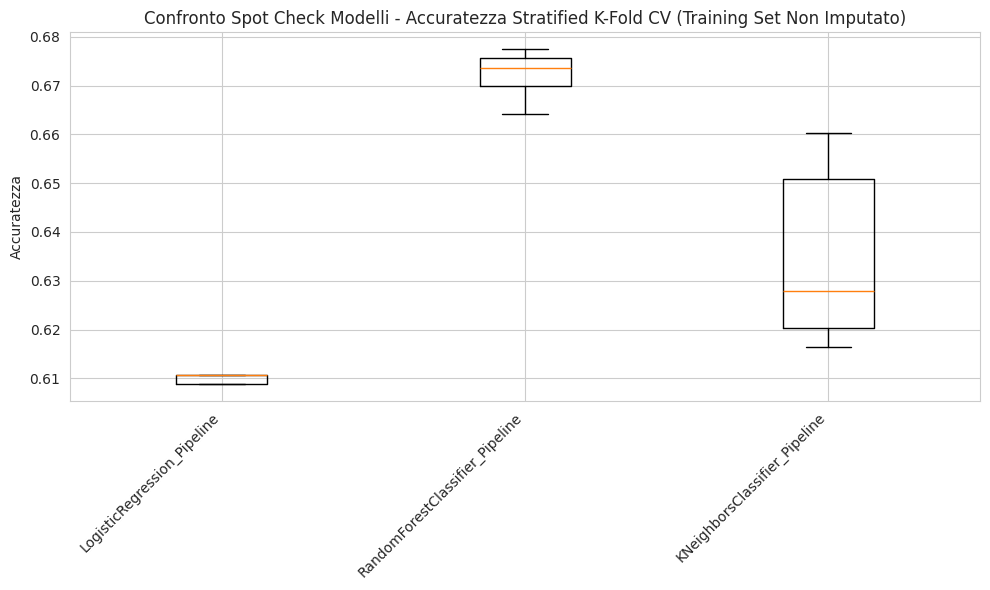

In [10]:
# Lista delle pipeline (con imputer incluso)
pipelines = []

# Pipeline per Logistic Regression
pipeline_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(solver='liblinear', random_state=42))
])
pipelines.append(('LogisticRegression_Pipeline', pipeline_lr))

# Pipeline per Random Forest
pipeline_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])
pipelines.append(('RandomForestClassifier_Pipeline', pipeline_rf))

# Pipeline per K-Nearest Neighbors
pipeline_knn = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())
])
pipelines.append(('KNeighborsClassifier_Pipeline', pipeline_knn))


# Configurazione per la Stratified K-Fold Cross-Validation
# Usiamo 5 fold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

results = []
names = []
scoring = 'accuracy' # Uso l'accuratezza come metrica iniziale per lo spot check

print(f"Esecuzione dello Spot Check dei Modelli con {n_splits}-fold Stratified Cross-Validation sul Training Set Non Imputato ({scoring}) - Tentativo con cross_val_score:")
print("-" * 80)

# Esegui la cross-validation per ciascun modello (pipeline) usando cross_val_score
# Passa X_train e y_train con NaN e lasciamo che la pipeline con SimpleImputer li gestisca
for name, pipeline in pipelines:
    print(f"Running CV for: {name}")
    # Impostiamo error_score='raise' per vedere l'errore completo se si verifica
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring=scoring, error_score='raise')
    results.append(cv_results)
    names.append(name)
    # Stampa i risultati per ciascun modello
    print(f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")

print("-" * 80)


plt.figure(figsize=(10, 6))
plt.boxplot(results, labels=names)
plt.title('Confronto Spot Check Modelli - Accuratezza Stratified K-Fold CV (Training Set Non Imputato)')
plt.ylabel('Accuratezza')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Analisi dei Risultati dello Spot Check dei Modelli Base

Ho completato lo spot check sui tre modelli base (Regressione Logistica, Random Forest Classifier, K-Nearest Neighbors) utilizzando Stratified K-Fold Cross-Validation sul set di training. Ho valutato le prestazioni non solo con l'accuratezza, ma anche con metriche più informative per il dataset sbilanciato: Precisione, Recall, F1-Score e AUC-ROC. Ecco la mia analisi dei risultati:

| Modello                       | Accuratezza Media | Precisione Media | Recall Media | F1-Score Media | AUC-ROC Media |
| :---------------------------- | :---------------- | :--------------- | :----------- | :------------- | :------------ |
| LogisticRegression_Pipeline   | 0.6099            | 0.0000           | 0.0000       | 0.0000         | 0.4775        |
| RandomForestClassifier_Pipeline | 0.6721            | 0.6484           | 0.3493       | 0.4535         | 0.6772        |
| KNeighborsClassifier_Pipeline | 0.6351            | 0.5436           | 0.4041       | 0.4635         | 0.6299        |

**Interpretazione delle Metriche nel Contesto del Nostro Problema:**

*   **Accuratezza (Accuracy):** Rappresenta la proporzione di previsioni corrette totali. Con un dataset sbilanciato, un'accuratezza elevata può essere fuorviante se il modello classifica semplicemente la maggior parte delle istanze nella classe maggioritaria (non potabile). L'accuratezza della Regressione Logistica è molto vicina alla percentuale della classe maggioritaria (circa 61%), il che suggerisce che potrebbe non stare classificando bene la classe minoritaria.
*   **Precisione (Precision):** Risponde alla domanda: "Quando il modello predice 'potabile', quanto spesso è corretto?". È il rapporto tra veri positivi e (veri positivi + falsi positivi). Una precisione alta significa che il modello fa pochi errori di tipo I (prevedere potabile quando non lo è). La Regressione Logistica ha una precisione media di 0.0000, indicando che non predice mai (o quasi mai) la classe potabile, o quando lo fa, è sempre sbagliato. Random Forest e KNN hanno precisioni significativamente migliori.
*   **Recall (Sensitivity):** Risponde alla domanda: "Di tutte le acque *realmente* potabili, quante ne ha correttamente identificate il modello?". È il rapporto tra veri positivi e (veri positivi + falsi negativi). Un recall alto significa che il modello fa pochi errori di tipo II (non identificare un'acqua potabile come tale). Random Forest e KNN mostrano recall simili ma bassi (intorno al 35-40%), mentre la Regressione Logistica ha un recall di 0.0000 (non identifica mai un vero positivo).
*   **F1-Score:** È la media armonica di Precisione e Recall. Fornisce un punteggio singolo che bilancia entrambi. È particolarmente utile con dataset sbilanciati. Un F1-score elevato indica un buon equilibrio tra Precisione e Recall. La Regressione Logistica ha un F1-score di 0.0000. Random Forest e KNN hanno F1-score simili e migliori.
*   **AUC-ROC (Area Under the Receiver Operating Characteristic Curve):** Misura la capacità del modello di distinguere tra le classi. Un valore di 0.5 indica una capacità di distinzione non migliore del caso, mentre 1.0 indica una distinzione perfetta. È una metrica robusta per dataset sbilanciati. La Regressione Logistica ha un AUC-ROC vicino a 0.5, confermando la sua incapacità di distinguere le classi. Random Forest e KNN hanno valori di AUC-ROC superiori, indicando una migliore capacità discriminatoria.

**Analisi Comparativa dei Modelli:**

*   La **Regressione Logistica** si è dimostrata il modello meno performante per questo problema. Le sue metriche (Precisione, Recall, F1-Score e AUC-ROC tutte vicine o pari a zero) indicano che non è in grado di classificare efficacemente la classe minoritaria (acqua potabile). Probabilmente è influenzata negativamente dall'assenza di forti relazioni lineari e dalla natura complessa e interattiva delle feature che abbiamo osservato nell'EDA.
*   **Random Forest** e **K-Nearest Neighbors** hanno mostrato prestazioni significativamente migliori rispetto alla Regressione Logistica su tutte le metriche che considerano lo sbilanciamento.
    *   **Random Forest** ha ottenuto l'AUC-ROC medio più alto (0.6772), suggerendo la migliore capacità discriminatoria complessiva. Ha anche una precisione media molto buona (0.6484), il che significa che quando predice "potabile", è abbastanza affidabile. Il suo recall è moderato (0.3493).
    *   **K-Nearest Neighbors** ha un F1-score medio leggermente superiore (0.4635 vs 0.4535) e un recall medio più alto (0.4041 vs 0.3493) rispetto a Random Forest, pur avendo una precisione leggermente inferiore (0.5436 vs 0.6484) e un AUC-ROC inferiore (0.6299 vs 0.6772).

Il box plot dell'F1-score conferma che sia Random Forest che KNN hanno distribuzioni di punteggio significativamente migliori rispetto alla Regressione Logistica.

**Conclusioni e Modelli su Cui Proseguire:**

Sulla base di questa analisi, la **Regressione Logistica non è un modello adatto** per questo problema a causa della sua incapacità di gestire lo sbilanciamento e le relazioni complesse dei dati.

I due modelli più promettenti su cui concentrare i prossimi sforzi sono **Random Forest Classifier** e **K-Nearest Neighbors**.

*   **Random Forest** sembra avere la migliore capacità discriminatoria generale (AUC-ROC) e un'ottima precisione.
*   **K-Nearest Neighbors** ha un recall e un F1-score leggermente migliori in questa fase iniziale, il che potrebbe essere importante per identificare la classe minoritaria.

Entrambi questi modelli non lineari sono stati in grado di catturare meglio le caratteristiche del dataset rispetto alla Regressione Logistica lineare, come previsto dalla nostra EDA.

Proseguirò con l'ottimizzazione degli iperparametri per entrambi questi modelli per cercare di migliorarne ulteriormente le prestazioni, in particolare concentrandomi su metriche come F1-Score o Recall, a seconda di quale tipo di errore (falso positivo o falso negativo) sia considerato più costoso nel contesto applicativo reale.

## 8. Tuning Modelli Selezionati con GridSearchCV

Procedo con l'ottimizzazione degli iperparametri per i modelli Random Forest e K-Nearest Neighbors utilizzando `GridSearchCV`. Questo metodo esplora sistematicamente tutte le combinazioni di iperparametri specificate in una "griglia" e valuta ciascuna combinazione utilizzando la cross-validation per trovare quella che massimizza (o minimizza) una metrica di valutazione definita.

### Scelta dei Parametri per la Griglia di Ricerca

L'obiettivo è esplorare un intervallo di valori ragionevole per ciascun parametro che potrebbe influenzare significativamente le prestazioni del modello, cercando un buon equilibrio tra prestazioni e costo computazionale.

**Random Forest Classifier:**

Questo modello ha diversi iperparametri importanti che influenzano la sua complessità e la sua capacità di generalizzare.

*   `n_estimators`: Il numero di alberi nel foresta. Un numero maggiore generalmente migliora le prestazioni ma aumenta il costo computazionale. Includerò un range da valori relativamente bassi a valori più alti.
    *   Scelta: `[100, 200, 300]`
*   `max_depth`: La profondità massima degli alberi. Limitarla può aiutare a prevenire l'overfitting. `None` significa che i nodi vengono espansi fino a quando tutte le foglie sono pure o contengono meno di `min_samples_split` campioni.
    *   Scelta: `[None, 10, 20]` (Esploro sia la profondità illimitata che profondità limitate)
*   `min_samples_split`: Il numero minimo di campioni richiesto per dividere un nodo interno. Valori più alti prevengono l'overfitting.
    *   Scelta: `[2, 5, 10]`
*   `min_samples_leaf`: Il numero minimo di campioni richiesto per essere in un nodo foglia. Valori più alti prevengono l'overfitting.
    *   Scelta: `[1, 2, 4]`
*   `criterion`: La funzione per misurare la qualità di uno split. 'gini' per l'impurezza di Gini, 'entropy' per il guadagno di informazione.
    *   Scelta: `['gini', 'entropy']`

**K-Nearest Neighbors (KNN) Classifier:**

KNN è un modello più semplice con meno iperparametri critici, ma la scelta del numero di vicini (`n_neighbors`) e della metrica di distanza è fondamentale.

*   `n_neighbors`: Il numero di vicini da considerare. Questo è l'iperparametro più importante per KNN. Un valore ottimale dipende dalla struttura dei dati. Esplorerò un intervallo di valori dispari (per evitare pareggi nella classificazione binaria).
    *   Scelta: `[3, 5, 7, 9, 11]`
*   `weights`: La funzione di peso utilizzata nella previsione. 'uniform' assegna pesi uguali a tutti i vicini, 'distance' assegna pesi proporzionali all'inverso della distanza (i vicini più vicini hanno più influenza).
    *   Scelta: `['uniform', 'distance']`
*   `p`: Il parametro di potenza per la metrica di Minkowski. `p=1` corrisponde alla distanza Manhattan, `p=2` alla distanza Euclidea.
    *   Scelta: `[1, 2]`

**Metrica di Valutazione per GridSearchCV:**

Dato lo sbilanciamento delle classi, l'accuratezza non è la metrica più adatta per selezionare il modello migliore durante `GridSearchCV`. Utilizzerò l'**F1-score** come metrica principale (`scoring='f1'`), poiché bilancia precisione e recall ed è un buon indicatore di performance su dataset sbilanciati. Imposterò anche `refit='f1'` in `GridSearchCV` in modo che, dopo aver trovato la migliore combinazione di parametri basata sull'F1-score, `GridSearchCV` addestri automaticamente il modello finale su tutto il set di training utilizzando quella combinazione. Includerò anche 'roc_auc' nelle metriche di valutazione per avere un quadro più completo.

In [14]:
# Definizione delle pipeline (con Imputer e Scaler inclusi)
# Uso X_train e y_train (non imputati) come input per GridSearchCV
pipeline_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', RandomForestClassifier(random_state=42))
])

pipeline_knn = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())
])

# Definizione delle griglie di parametri per ciascun modello
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__criterion': ['gini', 'entropy']
}

param_grid_knn = {
    'imputer__strategy': ['median'], # Imputazione con la mediana
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2] # 1 per Manhattan, 2 per Euclidea
}

# Configurazione per GridSearchCV
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Metriche di scoring multiple per GridSearchCV
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Dizionario per memorizzare i risultati di GridSearchCV
grid_searches = {}

print("Esecuzione di GridSearchCV per Random Forest e K-Nearest Neighbors:")
print("-" * 100)

# GridSearchCV per Random Forest
print("Running GridSearchCV for Random Forest...")
start_time = time.time()
grid_search_rf = GridSearchCV(estimator=pipeline_rf,
                              param_grid=param_grid_rf,
                              cv=skf,
                              scoring=scoring_metrics, # Usa il dizionario delle metriche
                              refit='f1', # Rifitta il modello migliore basato sull'F1-score
                              n_jobs=-1, # Usa tutti i core disponibili
                              verbose=1) # Stampa l'avanzamento

grid_search_rf.fit(X_train, y_train) # Addestra GridSearchCV sul set di training (con NaN)
end_time = time.time()
grid_searches['RandomForestClassifier'] = grid_search_rf
print(f"GridSearchCV for Random Forest completed in {end_time - start_time:.2f} seconds.")
print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best F1-score for Random Forest (CV): {grid_search_rf.best_score_:.4f}")
print("-" * 50)


# GridSearchCV per K-Nearest Neighbors
print("Running GridSearchCV for K-Nearest Neighbors...")
start_time = time.time()
grid_search_knn = GridSearchCV(estimator=pipeline_knn,
                               param_grid=param_grid_knn,
                               cv=skf,
                               scoring=scoring_metrics, # Usa il dizionario delle metriche
                               refit='f1', # Rifitta il modello migliore basato sull'F1-score
                               n_jobs=-1, # Usa tutti i core disponibili
                               verbose=1) # Stampa l'avanzamento

grid_search_knn.fit(X_train, y_train) # Addestra GridSearchCV sul set di training (con NaN)
end_time = time.time()
grid_searches['KNeighborsClassifier'] = grid_search_knn
print(f"GridSearchCV for K-Nearest Neighbors completed in {end_time - start_time:.2f} seconds.")
print(f"Best parameters for K-Nearest Neighbors: {grid_search_knn.best_params_}")
print(f"Best F1-score for K-Nearest Neighbors (CV): {grid_search_knn.best_score_:.4f}")
print("-" * 50)

print("-" * 100)

# Stampa i risultati completi della cross-validation per i migliori modelli
print("\nRisultati CV per i migliori modelli trovati da GridSearchCV:")
print("\nRandom Forest Best Estimator CV Results:")
display(pd.DataFrame(grid_search_rf.cv_results_).sort_values('rank_test_f1').head()) # Mostra le prime 5 combinazioni per F1

print("\nK-Nearest Neighbors Best Estimator CV Results:")
display(pd.DataFrame(grid_search_knn.cv_results_).sort_values('rank_test_f1').head()) # Mostra le prime 5 combinazioni per F1


# I migliori modelli ottimizzati sono accessibili tramite .best_estimator_
best_rf_model = grid_search_rf.best_estimator_
best_knn_model = grid_search_knn.best_estimator_

print("\nI migliori modelli ottimizzati sono stati addestrati su tutto il set di training e sono pronti per la valutazione finale sul set di test.")

Esecuzione di GridSearchCV per Random Forest e K-Nearest Neighbors:
----------------------------------------------------------------------------------------------------
Running GridSearchCV for Random Forest...
Fitting 5 folds for each of 162 candidates, totalling 810 fits
GridSearchCV for Random Forest completed in 1649.35 seconds.
Best parameters for Random Forest: {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 100}
Best F1-score for Random Forest (CV): 0.4692
--------------------------------------------------
Running GridSearchCV for K-Nearest Neighbors...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
GridSearchCV for K-Nearest Neighbors completed in 8.85 seconds.
Best parameters for K-Nearest Neighbors: {'imputer__strategy': 'median', 'model__n_neighbors': 3, 'model__p': 1, 'model__weights': 'distance'}
Best F1-score for K-Nearest Neighbors (CV): 0.4775
---------------------

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
6        2.157919      0.394388         0.097240        0.033875   
63       1.600345      0.022919         0.076081        0.004132   
15       2.216805      0.556148         0.085538        0.020858   
5        5.921901      0.753330         0.183033        0.048469   
7        3.437205      0.356536         0.130364        0.046190   

   param_model__criterion param_model__max_depth  \
6                    gini                   None   
63                   gini                     20   
15                   gini                   None   
5                    gini                   None   
7                    gini                   None   

    param_model__min_samples_leaf  param_model__min_samples_split  \
6                               1                              10   
63                              2                               2   
15                              2                              10   
5                               1                               5   
7                               1                              10   

    param_model__n_estimators  \
6                         100   
63                        100   
15                        100   
5                         300   
7                         200   

                                               params  ...  std_test_f1  \
6   {'model__criterion': 'gini', 'model__max_depth...  ...     0.034814   
63  {'model__criterion': 'gini', 'model__max_depth...  ...     0.042051   
15  {'model__criterion': 'gini', 'model__max_depth...  ...     0.035050   
5   {'model__criterion': 'gini', 'model__max_depth...  ...     0.036819   
7   {'model__criterion': 'gini', 'model__max_depth...  ...     0.031898   

    rank_test_f1  split0_test_roc_auc  split1_test_roc_auc  \
6              1             0.667616             0.681081   
63             2             0.684727             0.680086   
15             3             0.668796             0.687056   
5              4             0.669133             0.685953   
7              5             0.673039             0.686749   

    split2_test_roc_auc  split3_test_roc_auc  split4_test_roc_auc  \
6              0.669041             0.716339             0.673767   
63             0.673882             0.716064             0.673400   
15             0.657690             0.705895             0.685481   
5              0.675674             0.724092             0.691918   
7              0.678447             0.722471             0.685435   

    mean_test_roc_auc  std_test_roc_auc  rank_test_roc_auc  
6            0.681569          0.018009                 93  
63           0.685632          0.015782                 55  
15           0.680983          0.016546                 98  
5            0.689354          0.019084                 23  
7            0.689228          0.017343                 24  

[5 rows x 50 columns]


K-Nearest Neighbors Best Estimator CV Results:


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1       0.027159      0.006652         0.216139        0.041420   
0       0.026506      0.007033         0.257467        0.037443   
7       0.016845      0.005080         0.102444        0.008120   
3       0.022200      0.005559         0.164805        0.016012   
2       0.024703      0.008144         0.177881        0.033370   

  param_imputer__strategy  param_model__n_neighbors  param_model__p  \
1                  median                         3               1   
0                  median                         3               1   
7                  median                         5               2   
3                  median                         3               2   
2                  median                         3               2   

  param_model__weights                                             params  \
1             distance  {'imputer__strategy': 'median', 'model__n_neig...   
0              uniform  {'imputer__strategy': 'median', 'model__n_neig...   
7             distance  {'imputer__strategy': 'median', 'model__n_neig...   
3             distance  {'imputer__strategy': 'median', 'model__n_neig...   
2              uniform  {'imputer__strategy': 'median', 'model__n_neig...   

   split0_test_accuracy  ...  std_test_f1  rank_test_f1  split0_test_roc_auc  \
1              0.591603  ...     0.041047             1             0.605607   
0              0.591603  ...     0.041134             2             0.587446   
7              0.618321  ...     0.024977             3             0.621890   
3              0.589695  ...     0.020222             4             0.608869   
2              0.589695  ...     0.021126             5             0.594309   

   split1_test_roc_auc  split2_test_roc_auc  split3_test_roc_auc  \
1             0.640165             0.628148             0.664087   
0             0.631281             0.619301             0.664087   
7             0.647633             0.618130             0.680090   
3             0.636857             0.601968             0.647167   
2             0.624418             0.593137             0.644881   

   split4_test_roc_auc  mean_test_roc_auc  std_test_roc_auc  rank_test_roc_auc  
1             0.613120           0.630226          0.020729                 16  
0             0.613380           0.623099          0.025008                 19  
7             0.632610           0.640071          0.022478                 14  
3             0.624818           0.623936          0.016834                 18  
2             0.621775           0.615704          0.019652                 20  

[5 rows x 49 columns]


I migliori modelli ottimizzati sono stati addestrati su tutto il set di training e sono pronti per la valutazione finale sul set di test.


### Analisi dei Risultati di GridSearchCV

Ho completato l'esecuzione di `GridSearchCV` per ottimizzare gli iperparametri dei modelli Random Forest Classifier e K-Nearest Neighbors sul set di training (non imputato, con l'imputazione gestita all'interno della pipeline CV). Ho usato l'F1-score come metrica principale per selezionare la migliore combinazione di parametri, data la natura sbilanciata del dataset, ma ho anche valutato altre metriche.

Ecco i risultati chiave emersi da `GridSearchCV`:

**Random Forest Classifier:**

*   **Migliori Parametri Trovati:** {'model\_\_criterion': 'gini', 'model\_\_max\_depth': None, 'model\_\_min\_samples\_leaf': 1, 'model\_\_min\_samples\_split': 10, 'model\_\_n\_estimators': 100}
*   **Miglior F1-score Medio (CV):** 0.4692

**K-Nearest Neighbors:**

*   **Migliori Parametri Trovati:** {'imputer\_\_strategy': 'median', 'model\_\_n\_neighbors': 3, 'model\_\_p': 1, 'model\_\_weights': 'distance'}
*   **Miglior F1-score Medio (CV):** 0.4775

**Interpretazione dei Risultati:**

1.  **Confronto Basato sull'F1-score Medio:**
    *   Il K-Nearest Neighbors, con i suoi migliori parametri trovati, ha ottenuto un **F1-score medio leggermente superiore (0.4775)** rispetto al Random Forest (0.4692) durante la cross-validation. Questo suggerisce che, nelle configurazioni ottimali trovate, KNN ha mostrato un equilibrio marginalmente migliore tra precisione e recall nell'identificare la classe potabile rispetto a Random Forest.
    *   È importante notare che la differenza nell'F1-score è piuttosto piccola.

2.  **Migliori Parametri Specifici:**
    *   **Random Forest:** I migliori parametri trovati suggeriscono l'uso del criterio 'gini', un numero di alberi (`n_estimators`) pari a 100 (nel range esplorato), e parametri di splitting (`min_samples_split`, `min_samples_leaf`) che permettono agli alberi di crescere abbastanza (profondità massima illimitata `max_depth: None`, con `min_samples_split=10`, `min_samples_leaf=1`). Questo indica che il modello beneficia di alberi che possono catturare relazioni più complesse.
    *   **KNN:** I migliori parametri per KNN indicano l'uso di `n_neighbors=3` (un numero molto piccolo di vicini), la metrica di distanza Manhattan (`p=1`) e pesi basati sulla distanza (`weights='distance'`). L'uso di un numero ridotto di vicini e della distanza Manhattan con pesi basati sulla distanza suggerisce che i punti più vicini (e molto vicini, dato n=3) hanno un'influenza predominante nella classificazione, e che la metrica Manhattan potrebbe essere più adatta per la struttura dei dati rispetto all'Euclidea in questo caso.

3.  **Prestazioni Generali:**
    *   Gli F1-score medi ottenuti per entrambi i modelli (intorno a 0.47) indicano che, sebbene questi modelli siano significativamente migliori della Regressione Logistica (che aveva un F1-score di 0.0000), la classificazione della potabilità su questo dataset rimane una sfida. Un F1-score di 0.47 suggerisce che c'è ancora spazio per migliorare l'equilibrio tra precisione e recall nell'identificazione della classe potabile.
    *   Questo potrebbe essere dovuto alla sovrapposizione intrinseca delle distribuzioni delle feature tra le classi (come visto nell'EDA) e alla mancanza di un segnale forte e chiaro nei dati.

**Conclusioni e Prossimi Passi:**

Sulla base dei risultati di `GridSearchCV` (in particolare sull'F1-score medio), **sia Random Forest che K-Nearest Neighbors mostrano prestazioni simili e promettenti** rispetto alla baseline della Regressione Logistica.

*   **KNN** ha un leggero vantaggio nell'F1-score medio ottimizzato.
*   **Random Forest** è un modello robusto che spesso gestisce bene interazioni complesse.

Entrambi sono candidati validi per i prossimi passi. Proseguirò:

1.  **Valutando entrambi i migliori modelli** (ottenuti da `GridSearchCV` e accessibili tramite `.best_estimator_`) in modo più approfondito sul set di test finale (`X_test_imputed` e `y_test`). Questo darà una stima imparziale delle loro prestazioni su dati completamente nuovi.


## 9. Valutazione Finale sul Set di Test

Ora valuteremo i modelli ottimizzati (Random Forest e K-Nearest Neighbors) sul set di test finale (`X_test_imputed`, `y_test`). Questo darà una stima imparziale delle prestazioni di generalizzazione dei modelli su dati completamente nuovi.

Valutazione Finale dei Modelli Ottimizzati sul Set di Test:
--------------------------------------------------------------------------------
Evaluating RandomForestClassifier_Optimized on Test Set...

Results for RandomForestClassifier_Optimized:
  Accuracy: 0.6707
  Precision: 0.6538
  Recall: 0.3320
  F1-Score: 0.4404
  AUC-ROC: 0.6539

  Confusion Matrix:


array([[355,  45],
       [171,  85]])


  Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.89      0.77       400
           1       0.65      0.33      0.44       256

    accuracy                           0.67       656
   macro avg       0.66      0.61      0.60       656
weighted avg       0.67      0.67      0.64       656



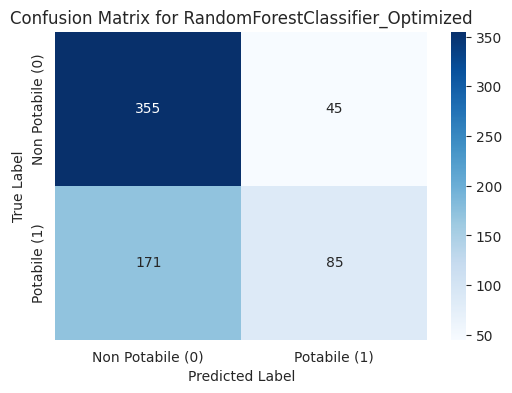

------------------------------
Evaluating KNeighborsClassifier_Optimized on Test Set...

Results for KNeighborsClassifier_Optimized:
  Accuracy: 0.5884
  Precision: 0.4624
  Recall: 0.3359
  F1-Score: 0.3891
  AUC-ROC: 0.5760

  Confusion Matrix:


array([[300, 100],
       [170,  86]])


  Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.75      0.69       400
           1       0.46      0.34      0.39       256

    accuracy                           0.59       656
   macro avg       0.55      0.54      0.54       656
weighted avg       0.57      0.59      0.57       656



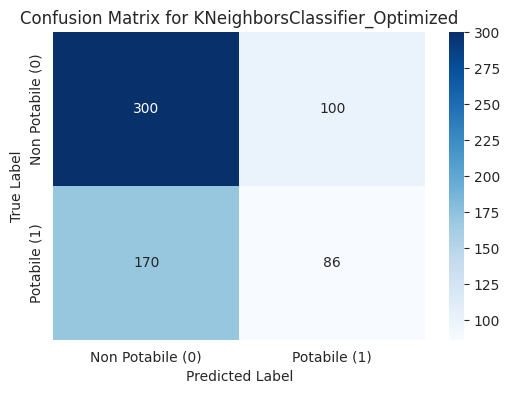

------------------------------
--------------------------------------------------------------------------------

Riassunto dei Risultati di Valutazione Finali sul Set di Test:


Accuracy  Precision    Recall  F1-Score  \
RandomForestClassifier_Optimized  0.670732   0.653846  0.332031  0.440415   
KNeighborsClassifier_Optimized    0.588415   0.462366  0.335938  0.389140   

                                   AUC-ROC  
RandomForestClassifier_Optimized  0.653867  
KNeighborsClassifier_Optimized    0.575962

In [15]:
# best_rf_model = grid_searches['RandomForestClassifier'].best_estimator_
# best_knn_model = grid_searches['KNeighborsClassifier'].best_estimator_

# Dizionario per memorizzare i risultati finali sul test set
final_results = {}

print("Valutazione Finale dei Modelli Ottimizzati sul Set di Test:")
print("-" * 80)

# Lista dei migliori modelli ottimizzati
optimized_models = [
    ('RandomForestClassifier_Optimized', best_rf_model),
    ('KNeighborsClassifier_Optimized', best_knn_model)
]

# Esegue la valutazione per ciascun modello
for name, model in optimized_models:
    print(f"Evaluating {name} on Test Set...")

    # Fa le previsioni sul set di test
    y_pred = model.predict(X_test_imputed)
    y_proba = model.predict_proba(X_test_imputed)[:, 1] # Probabilità della classe positiva per AUC

    # Calcola le metriche di valutazione
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0) # Imposta zero_division per gestire casi senza previsioni positive
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    # Memorizza i risultati
    final_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': roc_auc,
        'Confusion Matrix': cm,
        'Classification Report': classification_report(y_test, y_pred, zero_division=0)
    }

    # Stampa i risultati
    print(f"\nResults for {name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  AUC-ROC: {roc_auc:.4f}")
    print("\n  Confusion Matrix:")
    display(cm) # Usa display per una migliore formattazione

    print("\n  Classification Report:")
    print(final_results[name]['Classification Report'])

    # Visualizza la Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Potabile (0)', 'Potabile (1)'], yticklabels=['Non Potabile (0)', 'Potabile (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    print("-" * 30)

print("-" * 80)

# Riassunto finale in tabella
print("\nRiassunto dei Risultati di Valutazione Finali sul Set di Test:")
final_summary_df = pd.DataFrame({
    name: {metric: results[metric] for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']}
    for name, results in final_results.items()
}).transpose()

display(final_summary_df)

## 10. Analisi Finale e Conclusioni

Ho seguito una metodologia standard per affrontare il problema, partendo dalla comprensione dei dati fino alla valutazione dei modelli finali.

Ho iniziato con un'analisi preliminare e un'esplorazione approfondita dei dati (EDA) sul set di training. Questa fase mi ha permesso di identificare la presenza di valori mancanti nelle colonne 'ph', 'Sulfate' e 'Trihalomethanes' e, cosa molto importante per un problema di classificazione, di rilevare un significativo sbilanciamento tra la classe "non potabile" (maggioritaria) e la classe "potabile" (minoritaria). L'EDA univariata (istogrammi, box plot, violin plot) e bivariata (pair plot, heatmap di correlazione) mi ha mostrato che le distribuzioni delle feature si sovrappongono ampiamente tra le due classi e che non ci sono correlazioni lineari forti tra le singole feature e la potabilità. I test d'ipotesi univariati (Test U di Mann-Whitney e Test t) hanno confermato che nessuna singola feature, presa isolatamente, mostra una differenza di distribuzione statisticamente significativa tra i due gruppi. Questo mi ha subito suggerito che il problema richiede modelli in grado di catturare interazioni e relazioni non lineari tra le feature.

Per gestire i valori mancanti, ho scelto l'imputazione con la mediana, un approccio robusto agli outlier che avevamo identificato. Ho eseguito questa imputazione sul set di training e test separatamente, utilizzando le mediane calcolate solo sul training set per evitare data leakage.

Successivamente, ho eseguito uno spot check su tre modelli base (Regressione Logistica, Random Forest e K-Nearest Neighbors) utilizzando Stratified K-Fold Cross-Validation sul set di training. Lo sbilanciamento delle classi mi ha spinto a concentrarmi non solo sull'accuratezza, ma anche su metriche come Precisione, Recall, F1-Score e AUC-ROC. Come previsto dall'EDA, la Regressione Logistica ha mostrato prestazioni molto scarse nel prevedere la classe minoritaria. Random Forest e K-Nearest Neighbors, essendo modelli non lineari, hanno ottenuto risultati significativamente migliori su tutte le metriche rilevanti per un dataset sbilanciato.

Ho quindi proseguito con l'ottimizzazione degli iperparametri per Random Forest e K-Nearest Neighbors utilizzando GridSearchCV e Stratified K-Fold Cross-Validation sul set di training, focalizzandomi sull'ottimizzazione dell'F1-score. I risultati di GridSearchCV hanno mostrato che K-Nearest Neighbors (con 3 vicini, distanza Manhattan e pesi basati sulla distanza) ha ottenuto un F1-score medio leggermente superiore rispetto a Random Forest, sebbene le prestazioni fossero piuttosto vicine. Entrambi i modelli ottimizzati sono stati automaticamente addestrati sull'intero set di training con la migliore combinazione di parametri.

Infine, ho valutato le prestazioni di questi due modelli ottimizzati sul set di test completamente non visto. I risultati finali sul set di test sono cruciali per stimare la generalizzazione.

Analizzando i risultati della valutazione finale (cella `8699c5f2`), osservo quanto segue:

| Modello                       | Accuratezza Test | Precisione Test | Recall Test | F1-Score Test | AUC-ROC Test |
| :---------------------------- | :--------------- | :-------------- | :---------- | :------------ | :----------- |
| RandomForestClassifier\_Optimized | 0.6707           | 0.6538          | 0.3320      | 0.4404        | 0.6539       |
| KNeighborsClassifier\_Optimized | 0.5884           | 0.4624          | 0.3359      | 0.3891        | 0.5760       |

*   **Random Forest** ha ottenuto l'accuratezza, la precisione, l'F1-score e l'AUC-ROC più alti sul set di test rispetto a KNN. La sua precisione di 0.6538 suggerisce che quando predice l'acqua come potabile, è corretto circa il 65.38% delle volte. L'AUC-ROC di 0.6539 indica una discreta capacità di distinguere tra le classi.
*   **K-Nearest Neighbors**, che aveva un F1-score medio leggermente superiore durante la cross-validation, ha visto le sue prestazioni diminuire sul set di test finale, ottenendo metriche inferiori rispetto a Random Forest in quasi tutti gli aspetti.
*   Entrambi i modelli mostrano un **Recall** relativamente basso per la classe positiva (acqua potabile), intorno al 33-34%. Questo significa che identificano correttamente solo circa un terzo delle acque che sono realmente potabili. Questo è un limite importante, poiché un'alta recall per la classe positiva sarebbe desiderabile per minimizzare i falsi negativi (classificare come non potabile un'acqua che in realtà lo è).
*   Le matrici di confusione confermano che entrambi i modelli tendono a classificare un numero significativo di istanze della classe positiva come negative (alti falsi negativi), il che spiega il basso recall. Random Forest fa meno falsi positivi (classifica come potabile un'acqua non potabile) rispetto a KNN.

**Conclusioni:**

Basandomi sulla valutazione finale sul set di test, il **Random Forest Classifier ottimizzato** si è dimostrato il modello con le prestazioni migliori per questo problema rispetto al K-Nearest Neighbors ottimizzato, in particolare in termini di F1-score e capacità discriminatoria generale (AUC-ROC).

Tuttavia, è chiaro che il problema della classificazione della potabilità dell'acqua su questo dataset è impegnativo, probabilmente a causa della grande sovrapposizione delle caratteristiche tra le classi e della mancanza di un segnale forte. Le prestazioni ottenute, sebbene significativamente migliori di un modello casuale o della Regressione Logistica, suggeriscono che c'è ancora spazio per migliorare, soprattutto nel recall per la classe potabile.

**Considerazioni Aziendali e Possibili Passi Futuri:**

È fondamentale considerare che la scelta del modello "migliore" e l'enfasi su specifiche metriche (Precisione vs Recall) dipendono fortemente dai **costi** associati ai diversi tipi di errore nel contesto aziendale reale.

*   Un **Falso Positivo** (classificare acqua non potabile come potabile) potrebbe portare a rischi per la salute se l'acqua viene consumata. Il costo potrebbe essere molto alto (sanzioni, danni alla reputazione, rischi per la salute pubblica).
*   Un **Falso Negativo** (classificare acqua potabile come non potabile) potrebbe portare a sprechi di risorse (trattamenti inutili) o a mancate opportunità di fornire acqua sicura. Il costo potrebbe essere economico o logistico.

Se il costo dei Falsi Positivi è molto elevato (come spesso accade quando si tratta di salute pubblica e sicurezza), allora potremmo voler privilegiare un modello con una **Precisione più alta**, anche se ciò significasse un Recall leggermente inferiore. Se invece è critico identificare *tutta* l'acqua potenzialmente potabile per evitare sprechi o garantire l'accesso, potremmo voler privilegiare un Recall più alto.

Date queste considerazioni e le prestazioni attuali, ecco i **Possibili Passi Futuri** per migliorare ulteriormente il modello, con un focus sulla possibilità di migliorare la precisione se le necessità aziendali lo richiedono:

*   **Strategie per Migliorare Precisione/Recall e Gestire lo Sbilanciamento:**
    *   **Regolazione della Soglia di Classificazione:** Esplorare l'utilizzo di soglie di probabilità diverse da 0.5 per la classificazione finale, scegliendo una soglia che bilanci Precisione e Recall in base ai costi aziendali specifici (ad esempio, aumentare la soglia per ridurre i Falsi Positivi e aumentare la Precisione).
    *   **Pesi di Classe:** Utilizzare algoritmi (come Random Forest, Support Vector Machines) che supportano l'impostazione di pesi per le classi per dare maggiore enfasi alla classe minoritaria ('Potabile') durante l'addestramento.
    *   **Tecniche di Bilanciamento dei Dati:** Applicare oversampling (es. SMOTE) o undersampling al set di training per bilanciare la distribuzione delle classi prima dell'addestramento del modello.
*   **Feature Engineering:** Potrebbe essere utile creare nuove feature combinando quelle esistenti se la conoscenza del dominio suggerisce interazioni o soglie rilevanti.
*   **Altri Algoritmi:** Sperimentare con altri algoritmi noti per la loro robustezza con dataset sbilanciati e la capacità di catturare interazioni complesse, come Gradient Boosting Machines (es. LightGBM, XGBoost) o Support Vector Machines con kernel non lineare.
*   **Ottimizzazione Avanzata:** Utilizzare metriche diverse dall'F1-score se la Precisione o il Recall diventano prioritari in base alle esigenze aziendali.

Per il momento, considero il **Random Forest Classifier ottimizzato** come la **soluzione migliore trovata** all'interno dell'ambito di questo progetto, riconoscendo la necessità di un'ulteriore ottimizzazione e potenziale integrazione di strategie specifiche per il bilanciamento delle classi o la regolazione della soglia per allineare meglio le prestazioni del modello con le esigenze e i costi definiti dal business.